In [1]:
import lightning as L
from lightning.pytorch import loggers as pl_loggers
from lightning.pytorch.callbacks import TQDMProgressBar, ModelCheckpoint, EarlyStopping

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchmetrics
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchmetrics.classification import (
    AUROC,
)
from torchmetrics import (
    PearsonCorrCoef,
    SpearmanCorrCoef,
    Accuracy,
    R2Score
)

from tqdm import tqdm
import ast

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

plt.rcParams["savefig.bbox"] = 'tight'

# Supporting Functions

In [2]:
BATCH_SIZE = 512
device = "cuda"

class LModelA(L.LightningModule):
    def __init__(self, model, learning_rate, weight_decay):
        super().__init__()
        self.save_hyperparameters(ignore=['model'])
        self.model = model

        self.learning_rate = learning_rate
        self.weight_decay = weight_decay

        # Метрики для каждой стадии
        self.train_metrics_regression = self._make_metrics_regression("train_")
        self.validation_metrics_regression = self._make_metrics_regression("validation_")
        self.test_metrics_regression = self._make_metrics_regression("test_")

        self.train_metrics_classification = self._make_metrics_classification("train_")
        self.validation_metrics_classification = self._make_metrics_classification("validation_")
        self.test_metrics_classification = self._make_metrics_classification("test_")

        # self.loss_fn = nn.MSELoss()
        self.loss_fn = nn.HuberLoss()
        #self.loss_fn = nn.BCEWithLogitsLoss()

        self.cutoff = 1.0 - np.log(500) / np.log(50000)

    def _make_metrics_classification(self, prefix):
        metrics = torchmetrics.MetricCollection(
            {
                "auroc": AUROC(task="binary"),
                "accuracy": Accuracy(task="binary")
            },
            prefix=prefix
        )
        return metrics

    def _make_metrics_regression(self, prefix):
        metrics = torchmetrics.MetricCollection(
            {
                "pcc": PearsonCorrCoef(),
                "r2": R2Score()
            },
            prefix=prefix
        )
        return metrics


    def forward(self, mhc_embeddings, peptide_embeddings):
        return self.model(mhc_embeddings, peptide_embeddings)
        

    def _evaluate(self, batch, stage=None):

        mhc_embeddings, peptide_embeddings, length, scores = batch
        binary_scores = (scores >= self.cutoff).float()
        logits = self.forward(mhc_embeddings, peptide_embeddings)#.squeeze()        
        probs = logits.sigmoid()
        #loss = self.loss_fn(logits, binary_scores) # For BCE
        loss = self.loss_fn(probs, scores) # For regression

        metrics_dict = {f"{stage}_loss": loss}

        if stage == 'train':
            metrics_dict.update(self.train_metrics_regression(probs, scores))
            metrics_dict.update(self.train_metrics_classification(probs, binary_scores))
        elif stage == 'validation':
            metrics_dict.update(self.validation_metrics_regression(probs, scores))
            metrics_dict.update(self.validation_metrics_classification(probs, binary_scores))
        elif stage == 'test':
            metrics_dict.update(self.test_metrics_regression(probs, scores))
            metrics_dict.update(self.test_metrics_classification(probs, binary_scores))

        self.log_dict(metrics_dict, 
                      on_step=(stage == 'train'), 
                      on_epoch=True, 
                      prog_bar=True, 
                      sync_dist=True,
                      batch_size=BATCH_SIZE)

        return loss

    def training_step(self, batch, batch_idx):
        return self._evaluate(batch, stage='train')

    def validation_step(self, batch, batch_idx):
        self._evaluate(batch, stage='validation')

    def test_step(self, batch, batch_idx):
        self._evaluate(batch, stage='test')

    def on_train_epoch_end(self):
        self.train_metrics_classification.reset()
        self.train_metrics_regression.reset()

    def on_validation_epoch_end(self):
        self.log_dict(self.validation_metrics_regression.compute(),
                      on_step=False, on_epoch=True, 
                      prog_bar=True, sync_dist=True, 
                      batch_size=BATCH_SIZE)
        self.validation_metrics_regression.reset()

        self.log_dict(self.validation_metrics_classification.compute(),
                      on_step=False, on_epoch=True, 
                      prog_bar=True, sync_dist=True, 
                      batch_size=BATCH_SIZE)
        self.validation_metrics_classification.reset()

    

    def on_test_epoch_end(self):
        self.log_dict(self.test_metrics_regression.compute(),
                      on_step=False, on_epoch=True, 
                      prog_bar=True, sync_dist=True, 
                      batch_size=BATCH_SIZE)
        self.test_metrics_regression.reset()

        self.log_dict(self.test_metrics_classification.compute(),
                      on_step=False, on_epoch=True, 
                      prog_bar=True, sync_dist=True, 
                      batch_size=BATCH_SIZE)
        self.test_metrics_classification.reset()

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), 
                                      lr=self.learning_rate, 
                                      weight_decay=self.weight_decay)

        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=self.trainer.max_epochs,
            eta_min=1e-6
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 20,
            }
        }



In [3]:
class LModelAMask(L.LightningModule):
    def __init__(self, model, learning_rate, weight_decay):
        super().__init__()
        self.save_hyperparameters(ignore=['model'])
        self.model = model

        self.learning_rate = learning_rate
        self.weight_decay = weight_decay

        # Метрики для каждой стадии
        self.train_metrics_regression = self._make_metrics_regression("train_")
        self.validation_metrics_regression = self._make_metrics_regression("validation_")
        self.test_metrics_regression = self._make_metrics_regression("test_")

        self.train_metrics_classification = self._make_metrics_classification("train_")
        self.validation_metrics_classification = self._make_metrics_classification("validation_")
        self.test_metrics_classification = self._make_metrics_classification("test_")

        # self.loss_fn = nn.MSELoss()
        self.loss_fn = nn.HuberLoss()
        #self.loss_fn = nn.BCEWithLogitsLoss()

        self.cutoff = 1.0 - np.log(500) / np.log(50000)

    def _make_metrics_classification(self, prefix):
        metrics = torchmetrics.MetricCollection(
            {
                "auroc": AUROC(task="binary"),
                "accuracy": Accuracy(task="binary")
            },
            prefix=prefix
        )
        return metrics

    def _make_metrics_regression(self, prefix):
        metrics = torchmetrics.MetricCollection(
            {
                "pcc": PearsonCorrCoef(),
                "r2": R2Score()
            },
            prefix=prefix
        )
        return metrics


    def forward(self, mhc_embeddings, peptide_embeddings, mask):
        return self.model(mhc_embeddings, peptide_embeddings, mask)
        

    def _evaluate(self, batch, stage=None):

        mhc_embeddings, peptide_embeddings, mask, scores = batch
        binary_scores = (scores >= self.cutoff).float()
        logits = self.forward(mhc_embeddings, peptide_embeddings, mask)#.squeeze()        
        probs = logits.sigmoid()
        #loss = self.loss_fn(logits, binary_scores) # For BCE
        loss = self.loss_fn(probs, scores) # For regression

        metrics_dict = {f"{stage}_loss": loss}

        if stage == 'train':
            metrics_dict.update(self.train_metrics_regression(probs, scores))
            metrics_dict.update(self.train_metrics_classification(probs, binary_scores))
        elif stage == 'validation':
            metrics_dict.update(self.validation_metrics_regression(probs, scores))
            metrics_dict.update(self.validation_metrics_classification(probs, binary_scores))
        elif stage == 'test':
            metrics_dict.update(self.test_metrics_regression(probs, scores))
            metrics_dict.update(self.test_metrics_classification(probs, binary_scores))

        self.log_dict(metrics_dict, 
                      on_step=(stage == 'train'), 
                      on_epoch=True, 
                      prog_bar=True, 
                      sync_dist=True,
                      batch_size=BATCH_SIZE)

        return loss

    def training_step(self, batch, batch_idx):
        return self._evaluate(batch, stage='train')

    def validation_step(self, batch, batch_idx):
        self._evaluate(batch, stage='validation')

    def test_step(self, batch, batch_idx):
        self._evaluate(batch, stage='test')

    def on_train_epoch_end(self):
        self.train_metrics_classification.reset()
        self.train_metrics_regression.reset()

    def on_validation_epoch_end(self):
        self.log_dict(self.validation_metrics_regression.compute(),
                      on_step=False, on_epoch=True, 
                      prog_bar=True, sync_dist=True, 
                      batch_size=BATCH_SIZE)
        self.validation_metrics_regression.reset()

        self.log_dict(self.validation_metrics_classification.compute(),
                      on_step=False, on_epoch=True, 
                      prog_bar=True, sync_dist=True, 
                      batch_size=BATCH_SIZE)
        self.validation_metrics_classification.reset()

    

    def on_test_epoch_end(self):
        self.log_dict(self.test_metrics_regression.compute(),
                      on_step=False, on_epoch=True, 
                      prog_bar=True, sync_dist=True, 
                      batch_size=BATCH_SIZE)
        self.test_metrics_regression.reset()

        self.log_dict(self.test_metrics_classification.compute(),
                      on_step=False, on_epoch=True, 
                      prog_bar=True, sync_dist=True, 
                      batch_size=BATCH_SIZE)
        self.test_metrics_classification.reset()

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), 
                                      lr=self.learning_rate, 
                                      weight_decay=self.weight_decay)

        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=self.trainer.max_epochs,
            eta_min=1e-6
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 20,
            }
        }

In [4]:
def collate_fn(batch):
    proteins, peptides, lengths, scores, hla = zip(*batch)
    
    proteins = torch.stack(proteins)        # [B, 34, 1152]
    peptides = torch.stack(peptides)        # [B, 21, 1152] — уже паддинг
    lengths = torch.tensor(lengths)         # [B]
    scores = torch.tensor(scores)   #.unsqueeze(1)  # [B, 1]

    return proteins, peptides, lengths, scores, hla


class MHCSequenceDataset(Dataset):
    def __init__(self, df):
        self.df = df
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        score = row['score']
        alpha_path = row['alpha_path']
        beta_path = row['beta_path']
        peptide_path = row['peptide_path']
        alpha_positions = row['alpha_positions']
        beta_positions = row['beta_positions']
        hla = row["hla"]
                
        alpha_embeddings = np.load(alpha_path)[:, ast.literal_eval(alpha_positions), :].squeeze(0)
        beta_embeddings = np.load(beta_path)[:, ast.literal_eval(beta_positions), :].squeeze(0)
        peptide_embeddings = torch.FloatTensor(np.load(peptide_path))[:,1:-1].squeeze(0)

        peptide_len = peptide_embeddings.shape[0]

        # Паддинг по центру до 21
        total_pad = 21 - peptide_len
        left_pad = total_pad // 2
        right_pad = total_pad - left_pad
        peptide_padded = F.pad(peptide_embeddings, (0, 0, left_pad, right_pad), 'constant', value=0)
        protein = torch.FloatTensor(np.concatenate([alpha_embeddings, beta_embeddings], axis=0))

        # peptide_mask = torch.zeros(peptide_padded.size(0), dtype=torch.bool)
        # peptide_mask[peptide_len:] = True

        return protein, peptide_padded, peptide_len, torch.tensor(score, dtype=torch.float), hla

In [5]:
def collate_fn(batch):
    proteins, peptides, masks, scores, hla = zip(*batch)

    proteins = torch.stack(proteins) # [B, 34, 1152]
    peptides = torch.stack(peptides) # [B, 21, 1152]
    masks = torch.stack(masks) # [B, 21] — attention mask
    scores = torch.tensor(scores) # [B]

    return proteins, peptides, masks, scores, hla

class MHCSequenceDatasetMasked(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        score = row['score']
        alpha_path = row['alpha_path']
        beta_path = row['beta_path']
        peptide_path = row['peptide_path']
        alpha_positions = row['alpha_positions']
        beta_positions = row['beta_positions']
        hla = row["hla"]

        alpha_embeddings = np.load(alpha_path)[:, ast.literal_eval(alpha_positions), :].squeeze(0)
        beta_embeddings = np.load(beta_path)[:, ast.literal_eval(beta_positions), :].squeeze(0)
        peptide_embeddings = torch.FloatTensor(np.load(peptide_path))[:,1:-1].squeeze(0)

        peptide_len = peptide_embeddings.shape[0]

        # Паддинг по центру до 21
        total_pad = 21 - peptide_len
        left_pad = total_pad // 2
        right_pad = total_pad - left_pad
        peptide_padded = F.pad(peptide_embeddings, (0, 0, left_pad, right_pad), 'constant', value=0)

        # Маска: 1 — реальные токены, 0 — паддинг
        mask = torch.zeros(21, dtype=torch.bool)
        mask[left_pad:left_pad + peptide_len] = True

        protein = torch.FloatTensor(np.concatenate([alpha_embeddings, beta_embeddings], axis=0))

        return protein, peptide_padded, mask, torch.tensor(score, dtype=torch.float), hla

In [6]:
data = pd.read_csv("/home/user11/data/data_processed/data.tsv", sep="\t", names=["peptide", "score", "hla"])
#embeddings_table = pd.read_csv("/home/user11/data/embeddings_proteins/wide_data.tsv", sep="\t")
embeddings_table = pd.read_csv("/home/user11/data/embeddings_proteins/wide_data_32float.tsv", sep="\t")

i = 1

train = pd.read_csv(f"/home/user11/data/data_processed/train{i}", sep="\t", names=["peptide", "score", "hla"])
train.hla = train.hla.str.replace("_", "")
train_data = pd.merge(train, embeddings_table, on=["peptide", "score", "hla"])
train_data = train_data[train_data['peptide'].apply(len) <= 21]
train_data = train_data[train_data['peptide'].apply(len) >= 9]


val = pd.read_csv(f"/home/user11/data/data_processed/test{i}", sep="\t", names=["peptide", "score", "hla"])
val.hla = val.hla.str.replace("_", "")
val_data = pd.merge(val, embeddings_table, on=["peptide", "score", "hla"])
val_data = val_data[val_data['peptide'].apply(len) <= 21]
val_data = val_data[val_data['peptide'].apply(len) >= 9]

test_data = pd.read_csv("/home/user11/data/embeddings_proteins/wide_data_test.tsv", sep="\t")
test_data = pd.read_csv("/home/user11/data/embeddings_proteins/wide_data_test_32float.tsv", sep="\t")
print(len(test_data))
test_data = test_data[test_data['peptide'].apply(len) <= 21]
test_data = test_data[test_data['peptide'].apply(len) >= 9]
test_data = test_data.reset_index(drop=True)
print(len(test_data))


2052
2009


In [7]:
def compute_saliency(model, protein, peptide):
    protein.requires_grad_(True)
    peptide.requires_grad_(True)
    output = model(protein, peptide)[0]
    output.backward()
    
    # Aggregate gradients
    protein_importance = protein.grad.norm(dim=-1)  # [B, 34]
    peptide_importance = peptide.grad.norm(dim=-1)   # [B, 21]
    return protein_importance, peptide_importance

# ProteinPeptideInteractionModel

In [ ]:
class ProteinPeptideInteractionModel(nn.Module):
    def __init__(self, embedding_dim=1152, hidden_dim=512, num_heads=4, dropout=0.3):
        super(ProteinPeptideInteractionModel, self).__init__()
        
        self.peptide_proj = nn.Linear(embedding_dim, hidden_dim)
        self.protein_proj = nn.Linear(embedding_dim, hidden_dim)
        
        self.cross_attn = nn.MultiheadAttention(embed_dim=hidden_dim, 
                                                num_heads=num_heads, 
                                                batch_first=True,
                                                dropout=dropout)
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1),
        )
        
    def forward(self, protein, peptide):
        # protein: [B, 34, 1152]
        # peptide: [B, 21, 1152]
        
        # Проецируем эмбеддинги
        protein_proj = self.protein_proj(protein)   # [B, 34, hidden]
        peptide_proj = self.peptide_proj(peptide)   # [B, 21, hidden]
        
        # Кросс-аттеншн: пептид (query) взаимодействует с белком (key, value)
        attn_output, attn_weights = self.cross_attn(query=peptide_proj,
                                         key=protein_proj,
                                         value=protein_proj,
                                        average_attn_weights=False)
        # Агрегируем: берем среднее по всем позициям пептида
        attn_repr = attn_output.mean(dim=1)        # [B, hidden]
        pep_repr = peptide_proj.mean(dim=1)        # [B, hidden]
        
        combined = torch.cat([attn_repr, pep_repr], dim=1)  # [B, hidden*2]
        
        output = self.fc(combined)

        return output, combined, attn_weights

In [ ]:
best_model_path = "/home/user11/results/models/ProteinPeptideInteractionModel/version_11/checkpoints/best_model_epoch=epoch=31-auroc=validation_auroc=0.8308.ckpt"
obj_model = ProteinPeptideInteractionModel(embedding_dim=1152, hidden_dim=512, num_heads=8, dropout=0.2)
model = LModelA.load_from_checkpoint(best_model_path, model=obj_model)

In [57]:
weight = 0
for protein, peptide_padded, peptide_len, score in tqdm(DataLoader(MHCSequenceDataset(val_data), batch_size=512)):
    weight += model(protein, peptide_padded)[1].squeeze().detach().numpy().sum(axis=0)

100%|██████████| 52/52 [01:59<00:00,  2.29s/it]


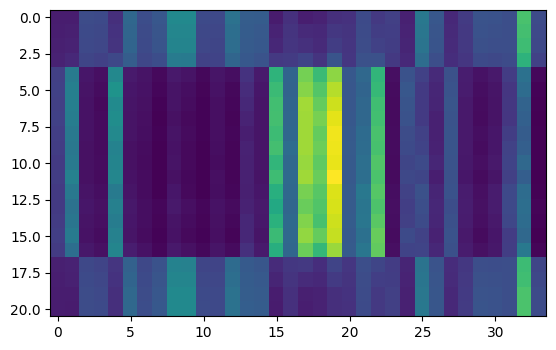

In [58]:
plt.imshow(weight / len(val_data))

In [108]:
best_model_path = "/home/user11/results/models/ProteinPeptideInteractionModel/version_11/checkpoints/best_model_epoch=epoch=31-auroc=validation_auroc=0.8308.ckpt"
device = "cuda:3"
obj_model = ProteinPeptideInteractionModel(embedding_dim=1152, hidden_dim=512, num_heads=8, dropout=0.2)
model = LModelA.load_from_checkpoint(best_model_path, model=obj_model).to(device)

In [ ]:
weight = 0
for protein, peptide_padded, peptide_len, score in tqdm(DataLoader(MHCSequenceDataset(val_data), batch_size=512)):
    weight += model(protein.to(device), peptide_padded.to(device))[1].detach().cpu().numpy().sum(axis=0)


100%|██████████| 52/52 [01:47<00:00,  2.07s/it]


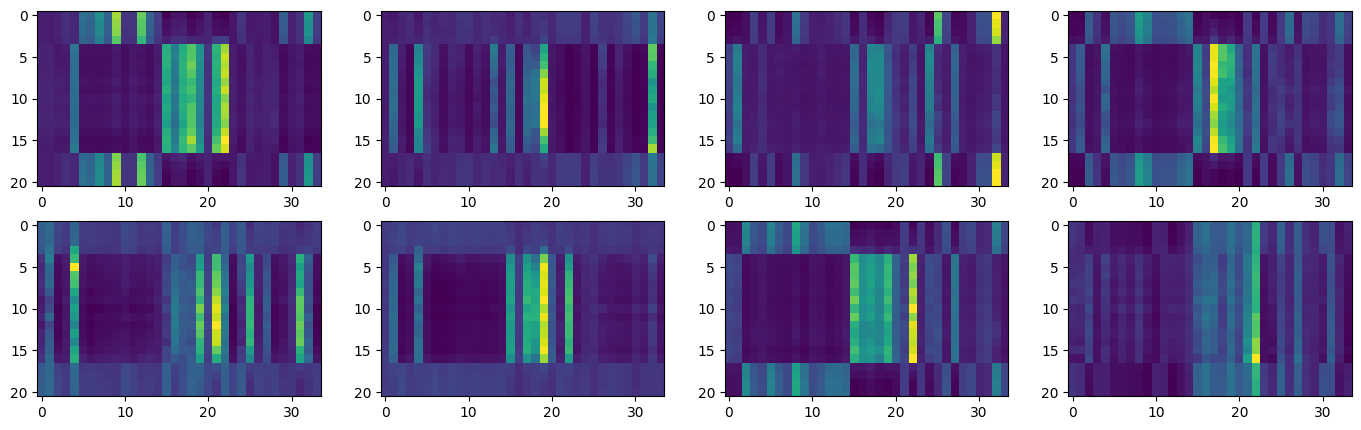

In [87]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(17, 5))

for i, w in enumerate(weight):
    ax = axs.ravel()[i]

    ax.imshow(w)

In [109]:
for protein, peptide_padded, peptide_len, score, hla in tqdm(DataLoader(MHCSequenceDataset(val_data), batch_size=2048)):
    embeddings = model(protein.to(device), peptide_padded.to(device))[2].detach().cpu().numpy()

    break

  0%|          | 0/13 [00:08<?, ?it/s]


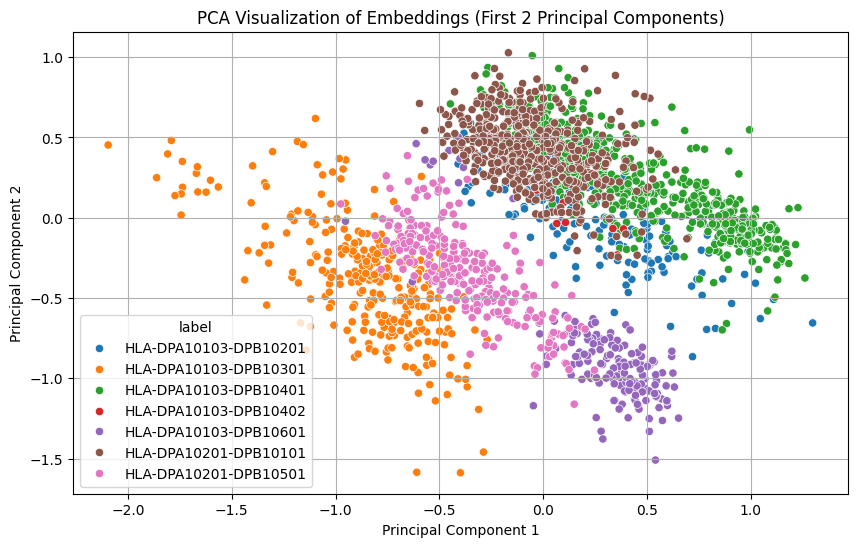

In [ ]:
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

viz_df = pd.DataFrame(reduced_embeddings, columns=['PC1', 'PC2'])
viz_df["label"] = hla

labels = hla
unique_labels = np.unique(labels)
label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
y_int = np.array([label_to_int[label] for label in labels])

plt.figure(figsize=(10, 6))
# plt.scatter(viz_df['PC1'], viz_df['PC2'], alpha=0.7, edgecolor='k', c=y_int)
sns.scatterplot(data=viz_df, x="PC1", y="PC2", hue="label")
plt.title('PCA Visualization of Embeddings (First 2 Principal Components)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

# ProteinPeptideInteractionModelWithSmartGate and ProteinPeptideInteractionModelWithSmartGateMask

In [6]:
class ProteinPeptideInteractionModelWithSmartGate(nn.Module):
    def __init__(self, embedding_dim=1152, hidden_dim=512, num_heads=4, dropout=0.3):
        super(ProteinPeptideInteractionModelWithSmartGate, self).__init__()
        
        self.peptide_proj = nn.Linear(embedding_dim, hidden_dim)
        self.protein_proj = nn.Linear(embedding_dim, hidden_dim)
        
        self.cross_attn = nn.MultiheadAttention(embed_dim=hidden_dim, 
                                                num_heads=num_heads, 
                                                batch_first=True,
                                                dropout=dropout)
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1),
        )
        
        self.gate  = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 2)
        )

    def forward(self, protein, peptide):
        # protein: [B, 34, 1152]
        # peptide: [B, 21, 1152]
        
        # Проецируем эмбеддинги
        protein_proj = self.protein_proj(protein)   # [B, 34, hidden]
        peptide_proj = self.peptide_proj(peptide)   # [B, 21, hidden]
        
        # Кросс-аттеншн: пептид (query) взаимодействует с белком (key, value)
        attn_output, attn_weights = self.cross_attn(query=peptide_proj,
                                         key=protein_proj,
                                         value=protein_proj,
                                        average_attn_weights=False)
        # Агрегируем: берем среднее по всем позициям пептида
        attn_repr = attn_output.mean(dim=1)        # [B, hidden]
        pep_repr = peptide_proj.mean(dim=1)        # [B, hidden]
        
        combined = torch.cat([attn_repr, pep_repr], dim=1)  # [B, hidden*2]
        alpha, beta = self.gate(combined).chunk(chunks=2, dim=-1)

        combined_2 = torch.cat([attn_repr * alpha, pep_repr * beta], dim=1)
        output = self.fc(combined_2)

        return output, combined, combined_2, attn_weights

In [74]:
class ProteinPeptideInteractionModelWithSmartGateMask(nn.Module):
    def __init__(self, embedding_dim=1152, hidden_dim=512, num_heads=4, dropout=0.3):
        super(ProteinPeptideInteractionModelWithSmartGateMask, self).__init__()

        self.peptide_proj = nn.Linear(embedding_dim, hidden_dim)
        self.protein_proj = nn.Linear(embedding_dim, hidden_dim)

        self.cross_attn = nn.MultiheadAttention(
            embed_dim=hidden_dim,
            num_heads=num_heads,
            batch_first=True,
            dropout=dropout
        )

        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1),
        )

        self.gate = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 2)
        )

    def forward(self, protein, peptide, peptide_mask):
        """
        protein: [B, 34, 1152]
        peptide: [B, 21, 1152]
        peptide_mask: [B, 21] — bool tensor (True = настоящий токен, False = паддинг)
        """
        # Проекции
        protein_proj = self.protein_proj(protein) # [B, 34, hidden]
        peptide_proj = self.peptide_proj(peptide) # [B, 21, hidden]

        # Кросс-аттеншн
        attn_output, attn_weights = self.cross_attn(
            query=peptide_proj,
            key=protein_proj,
            value=protein_proj,
            key_padding_mask=None, # не нужен, так как белок фиксированной длины
            average_attn_weights=False
        )

        # Маска: [B, 21, 1]
        mask = peptide_mask.unsqueeze(-1).float() # float: True → 1.0, False → 0.0
        mask_sum = mask.sum(dim=1).clamp(min=1.0) # избегаем деления на 0

        # Маскированное среднее
        attn_repr = (attn_output * mask).sum(dim=1) / mask_sum # [B, hidden]
        pep_repr = (peptide_proj * mask).sum(dim=1) / mask_sum # [B, hidden]

        # Smart Gate
        combined_1 = torch.cat([attn_repr, pep_repr], dim=1) # [B, hidden*2]
        alpha, beta = self.gate(combined_1).chunk(2, dim=-1) # [B, hidden], [B, hidden]
        combined_2 = torch.cat([attn_repr * alpha, pep_repr * beta], dim=1) # [B, hidden*2]
        output = self.fc(combined_2)
        return output, combined_1, combined_2, attn_weights # [B, 1]

In [58]:
best_model_path = "/home/user11/results/models/ProteinPeptideInteractionWithSmartGate/version_0/checkpoints/best_model_epoch=epoch=45-auroc=validation_auroc=0.8295.ckpt"
obj_model = ProteinPeptideInteractionModelWithSmartGate(embedding_dim=1152, hidden_dim=512, num_heads=8, dropout=0.2)
model = LModelA.load_from_checkpoint(best_model_path, model=obj_model)

In [ ]:
for protein, peptide_padded, peptide_len, score, hla in tqdm(DataLoader(MHCSequenceDataset(val_data), batch_size=2048)):
    output, combined_1, combined_2, attn_weights = model(protein.to(device), peptide_padded.to(device))

    break

  0%|          | 0/13 [00:17<?, ?it/s]


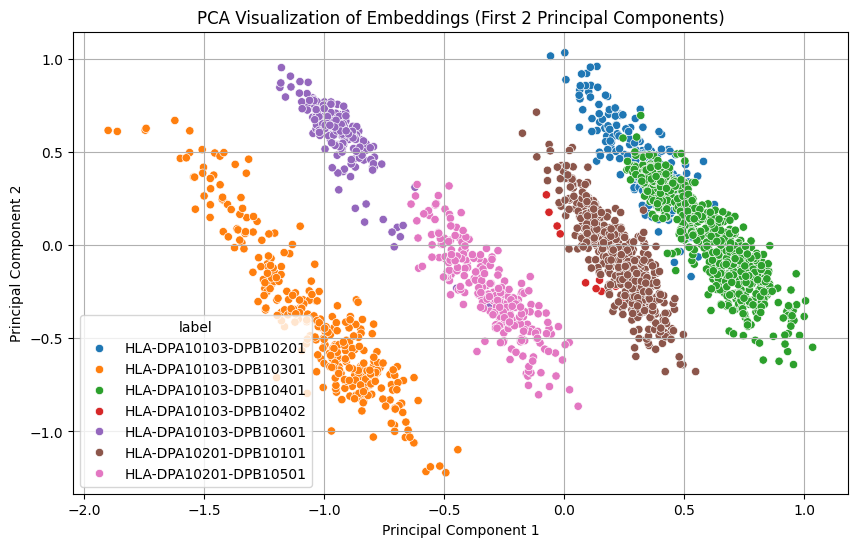

In [ ]:
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(combined_1.detach().cpu().numpy())

viz_df = pd.DataFrame(reduced_embeddings, columns=['PC1', 'PC2'])
viz_df["label"] = hla

labels = hla
unique_labels = np.unique(labels)
label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
y_int = np.array([label_to_int[label] for label in labels])

plt.figure(figsize=(10, 6))
# plt.scatter(viz_df['PC1'], viz_df['PC2'], alpha=0.7, edgecolor='k', c=y_int)
sns.scatterplot(data=viz_df, x="PC1", y="PC2", hue="label")
plt.title('PCA Visualization of Embeddings (First 2 Principal Components)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

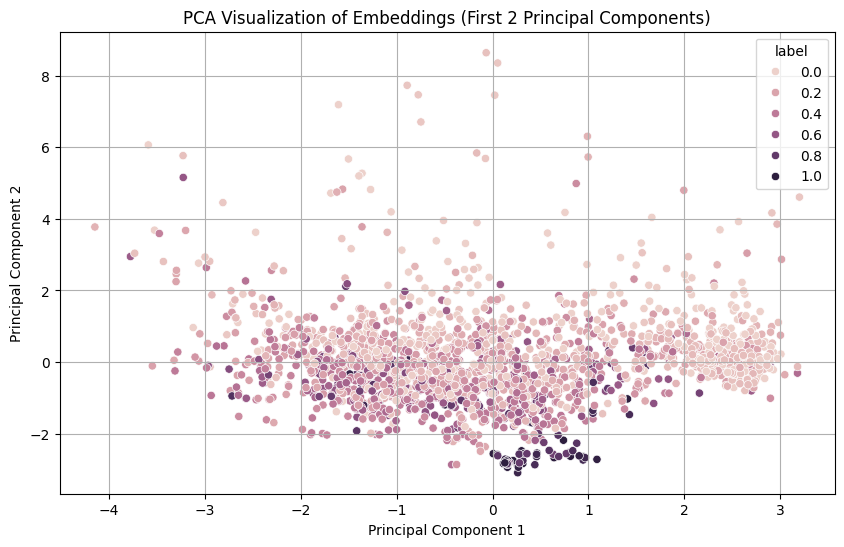

In [37]:
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(combined_2.detach().cpu().numpy())

# Step 2: Create a DataFrame for visualization
viz_df = pd.DataFrame(reduced_embeddings, columns=['PC1', 'PC2'])

viz_df["label"] = score
# Step 3: Plot

labels = hla
unique_labels = np.unique(labels)
label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
y_int = np.array([label_to_int[label] for label in labels])

plt.figure(figsize=(10, 6))
# plt.scatter(viz_df['PC1'], viz_df['PC2'], alpha=0.7, edgecolor='k', c=y_int)
sns.scatterplot(data=viz_df, x="PC1", y="PC2", hue="label")
plt.title('PCA Visualization of Embeddings (First 2 Principal Components)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

100%|██████████| 52/52 [03:16<00:00,  3.79s/it]


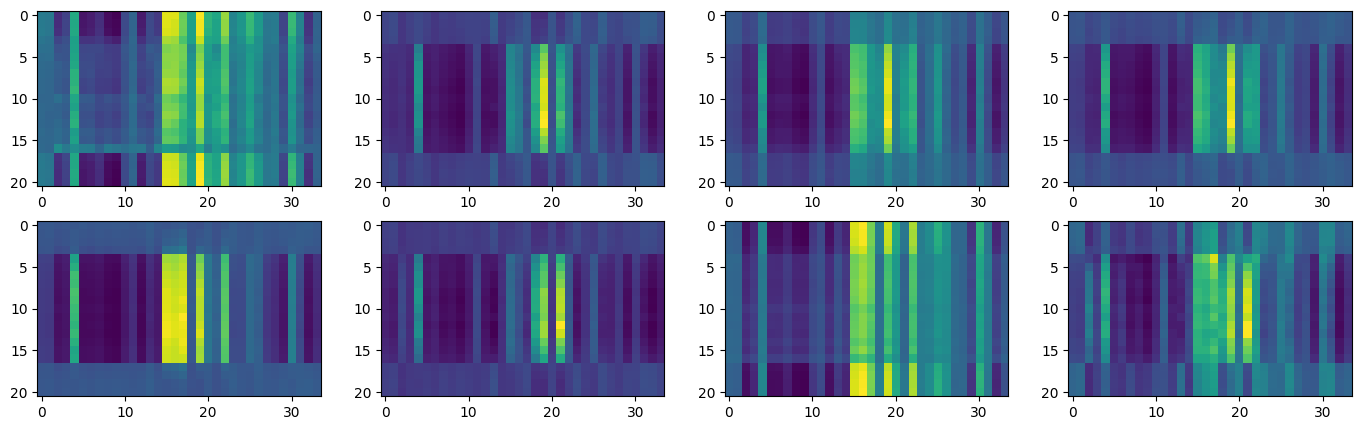

In [40]:
weight = 0
for protein, peptide_padded, peptide_len, score, hla in tqdm(DataLoader(MHCSequenceDataset(val_data), batch_size=512)):
    weight += model(protein.to(device), peptide_padded.to(device))[3].detach().cpu().numpy().sum(axis=0)

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(17, 5))

for i, w in enumerate(weight):
    ax = axs.ravel()[i]

    ax.imshow(w)

  0%|          | 5/26343 [00:00<1:24:58,  5.17it/s]


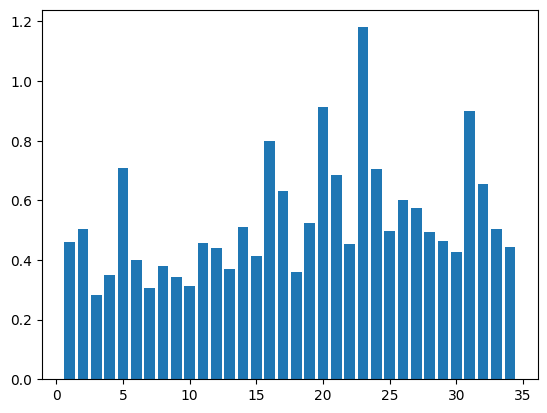

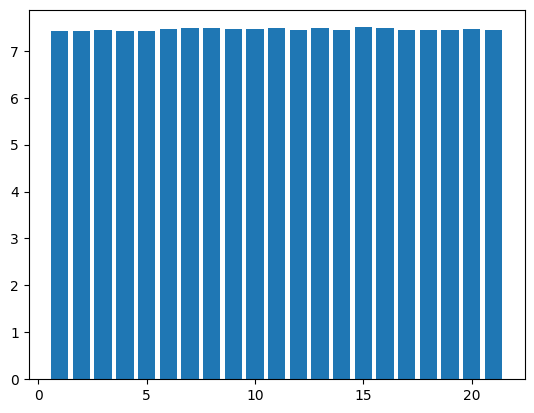

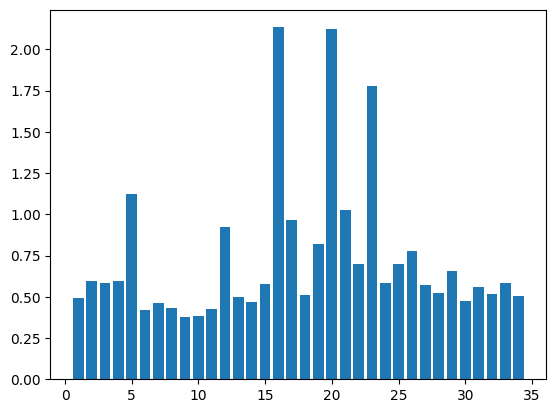

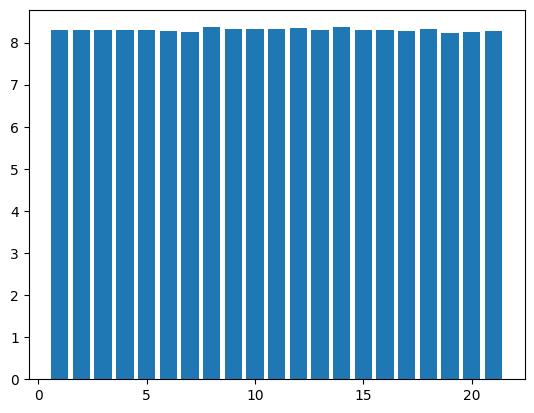

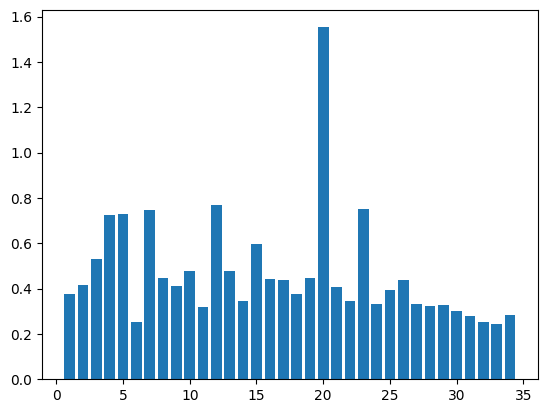

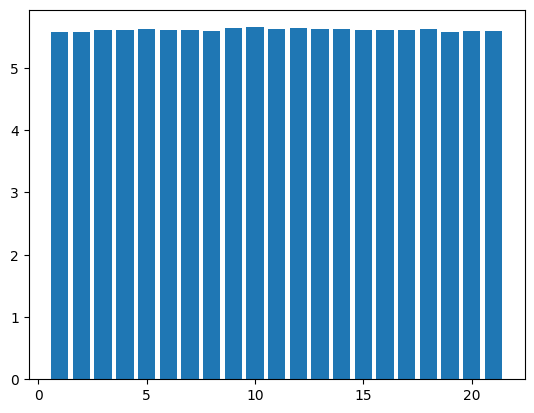

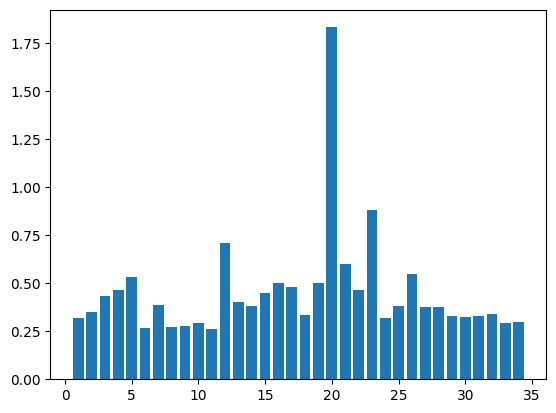

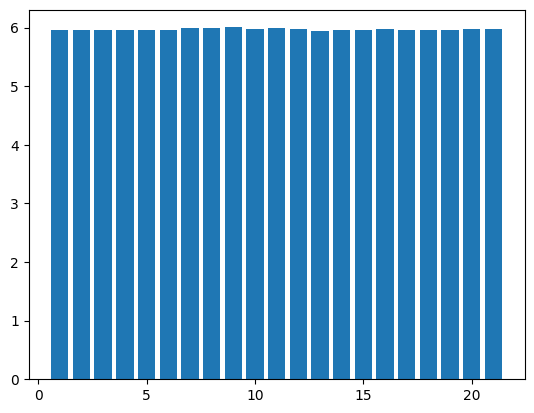

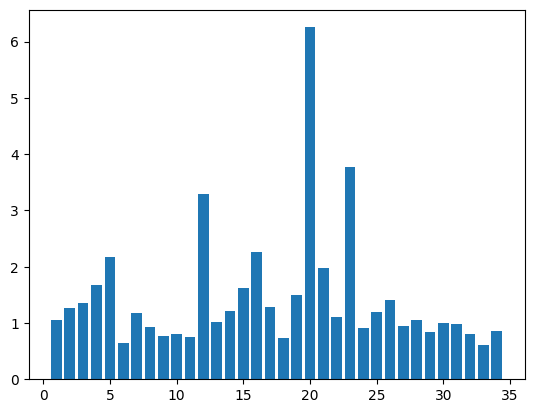

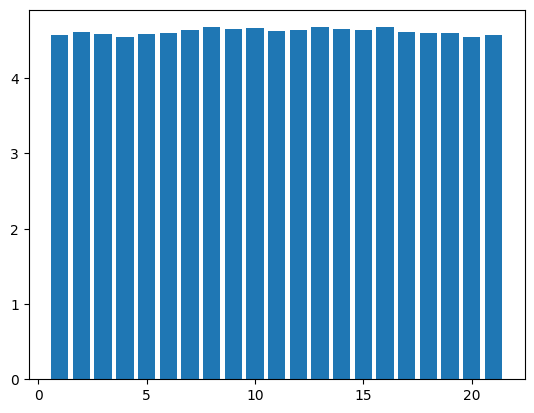

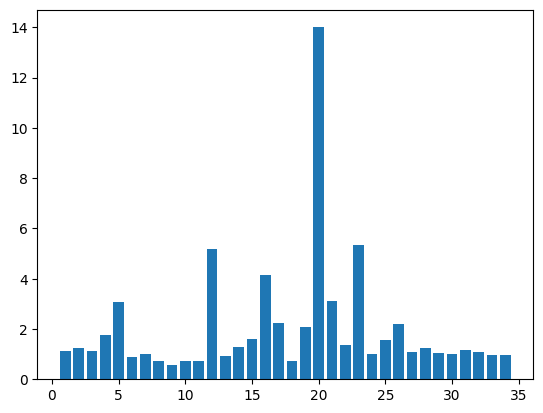

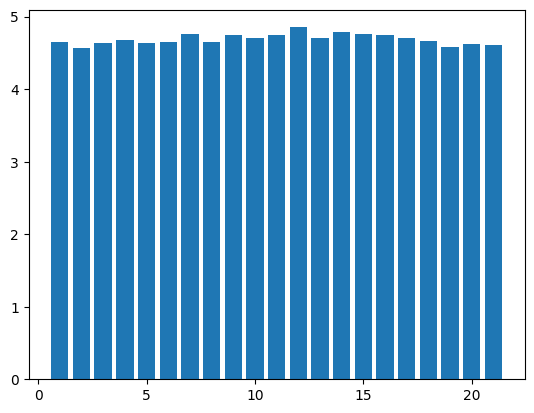

In [59]:
i = 0
for protein, peptide_padded, peptide_len, score, hla in tqdm(DataLoader(MHCSequenceDataset(val_data), batch_size=1)):
    protein_importance, peptide_importance = compute_saliency(model.to(device), protein.to(device), peptide_padded.to(device))

    plt.figure()
    plt.bar(np.arange(1, 35), protein_importance.detach().cpu().numpy()[0])
    plt.figure()
    plt.bar(np.arange(1, 22), peptide_importance.detach().cpu().numpy()[0])


    if i == 5:
        break
    else:
        i += 1

In [44]:
class ProteinPeptideInteractionModel(nn.Module):
    def __init__(self, embedding_dim=1152, hidden_dim=512, num_heads=4, dropout=0.3):
        super(ProteinPeptideInteractionModel, self).__init__()
        
        self.peptide_proj = nn.Linear(embedding_dim, hidden_dim)
        self.protein_proj = nn.Linear(embedding_dim, hidden_dim)
        
        self.cross_attn = nn.MultiheadAttention(embed_dim=hidden_dim, 
                                                num_heads=num_heads, 
                                                batch_first=True,
                                                dropout=dropout)
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1),
        )
        
    def forward(self, protein, peptide):
        # protein: [B, 34, 1152]
        # peptide: [B, 21, 1152]
        
        # Проецируем эмбеддинги
        protein_proj = self.protein_proj(protein)   # [B, 34, hidden]
        peptide_proj = self.peptide_proj(peptide)   # [B, 21, hidden]
        
        # Кросс-аттеншн: пептид (query) взаимодействует с белком (key, value)
        attn_output, attn_weights = self.cross_attn(query=peptide_proj,
                                         key=protein_proj,
                                         value=protein_proj,
                                        average_attn_weights=False)
        # Агрегируем: берем среднее по всем позициям пептида
        attn_repr = attn_output.mean(dim=1)        # [B, hidden]
        pep_repr = peptide_proj.mean(dim=1)        # [B, hidden]
        
        combined = torch.cat([attn_repr, pep_repr], dim=1)  # [B, hidden*2]
        
        output = self.fc(combined)

        return output, combined, attn_weights

In [45]:
best_model_path ="/home/user11/results/models/ProteinPeptideInteractionModelMask/version_1/checkpoints/best_model_epoch=epoch=67-auroc=validation_auroc=0.8283.ckpt"
obj_model = ProteinPeptideInteractionModel(embedding_dim=1152, hidden_dim=512, num_heads=8, dropout=0.2)
model = LModelA.load_from_checkpoint(best_model_path, model=obj_model)

  0%|          | 0/13 [00:14<?, ?it/s]


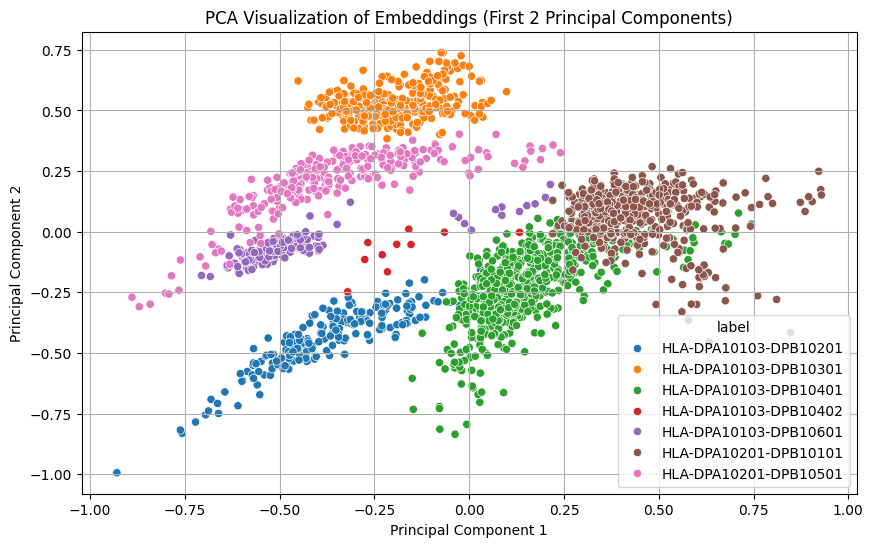

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

for protein, peptide_padded, peptide_len, score, hla in tqdm(DataLoader(MHCSequenceDataset(val_data), batch_size=2048)):
    output, combined, attn_weights = model(protein.to(device), peptide_padded.to(device))

    break
# Step 1: Apply PCA to reduce to 2 components
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(combined.detach().cpu().numpy())

# Step 2: Create a DataFrame for visualization
viz_df = pd.DataFrame(reduced_embeddings, columns=['PC1', 'PC2'])

viz_df["label"] = hla
# Step 3: Plot

labels = hla
unique_labels = np.unique(labels)
label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
y_int = np.array([label_to_int[label] for label in labels])

plt.figure(figsize=(10, 6))
# plt.scatter(viz_df['PC1'], viz_df['PC2'], alpha=0.7, edgecolor='k', c=y_int)
sns.scatterplot(data=viz_df, x="PC1", y="PC2", hue="label")
plt.title('PCA Visualization of Embeddings (First 2 Principal Components)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

In [ ]:
weight = 0
for protein, peptide_padded, peptide_len, score, hla in tqdm(DataLoader(MHCSequenceDataset(val_data), batch_size=2058)):
    weight += model(protein.to(device), peptide_padded.to(device))[2].detach().cpu().numpy().sum(axis=0)

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(17, 5))

for i, w in enumerate(weight):
    ax = axs.ravel()[i]

    ax.imshow(w)

# ProteinPeptideInteractionModelWithSmartGateMask 4 heads

In [83]:
best_model_path ="/home/user11/results/models/ProteinPeptideInteractionModelWithSmartGateMask/version_0/checkpoints/best_model_epoch=epoch=48-auroc=validation_auroc=0.8271.ckpt"
obj_model = ProteinPeptideInteractionModelWithSmartGateMask(embedding_dim=1152, hidden_dim=512, num_heads=4, dropout=0.2)
model = LModelAMask.load_from_checkpoint(best_model_path, model=obj_model).to(device)

In [ ]:
for protein, peptide_padded, peptide_mask, score, hla in tqdm(DataLoader(MHCSequenceDatasetMasked(val_data), batch_size=2000)):
    output, combined_1, combined_2, attn_weights = model(protein.to(device), peptide_padded.to(device), peptide_mask.to(device))

    break

  0%|          | 0/14 [00:02<?, ?it/s]


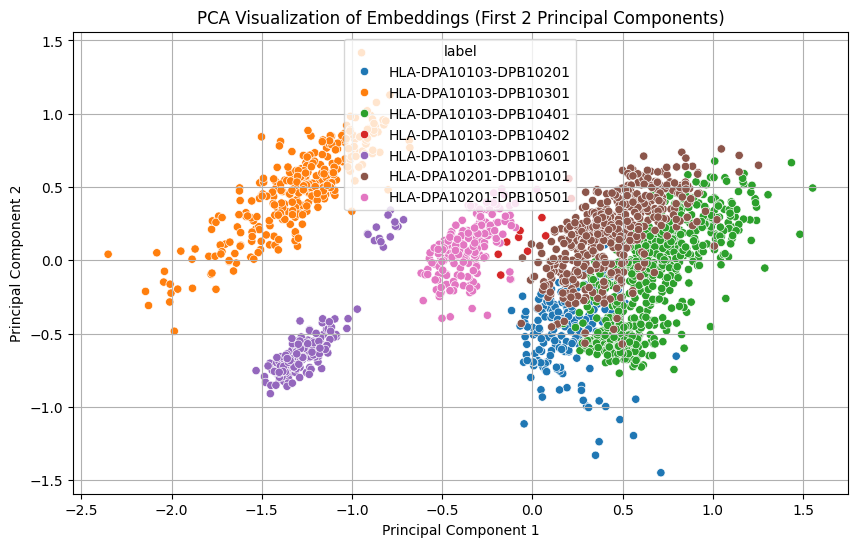

In [ ]:
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(combined_1.detach().cpu().numpy())

viz_df = pd.DataFrame(reduced_embeddings, columns=['PC1', 'PC2'])
viz_df["label"] = hla

labels = hla
unique_labels = np.unique(labels)
label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
y_int = np.array([label_to_int[label] for label in labels])

plt.figure(figsize=(10, 6))
# plt.scatter(viz_df['PC1'], viz_df['PC2'], alpha=0.7, edgecolor='k', c=y_int)
sns.scatterplot(data=viz_df, x="PC1", y="PC2", hue="label")
plt.title('PCA Visualization of Embeddings (First 2 Principal Components)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

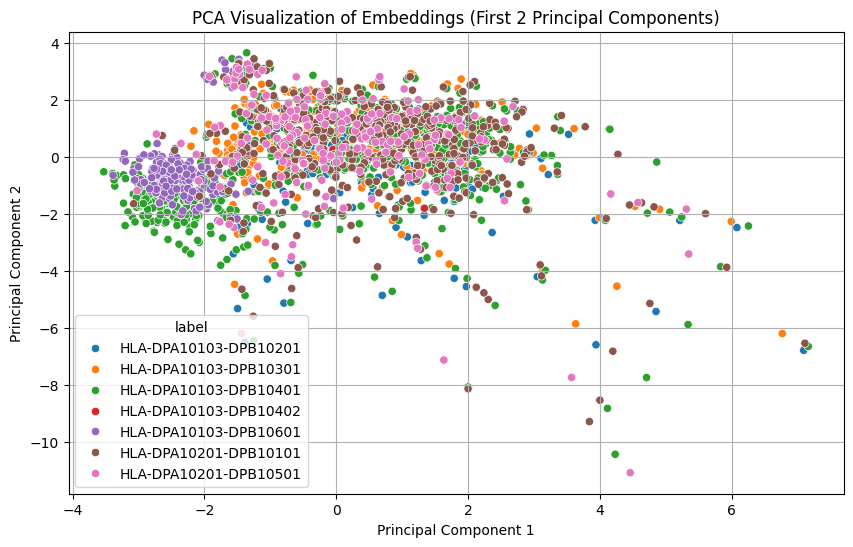

In [ ]:
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(combined_2.detach().cpu().numpy())

viz_df = pd.DataFrame(reduced_embeddings, columns=['PC1', 'PC2'])
viz_df["label"] = hla

labels = hla
unique_labels = np.unique(labels)
label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
y_int = np.array([label_to_int[label] for label in labels])

plt.figure(figsize=(10, 6))
# plt.scatter(viz_df['PC1'], viz_df['PC2'], alpha=0.7, edgecolor='k', c=y_int)
sns.scatterplot(data=viz_df, x="PC1", y="PC2", hue="label")
plt.title('PCA Visualization of Embeddings (First 2 Principal Components)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

In [91]:
weight = 0
for protein, peptide_padded, peptide_mask, score, hla in tqdm(DataLoader(MHCSequenceDatasetMasked(val_data), batch_size=2058)):
    weight += model(protein.to(device), peptide_padded.to(device), peptide_mask.to(device))[3].detach().cpu().numpy().sum(axis=0)

100%|██████████| 13/13 [00:35<00:00,  2.73s/it]


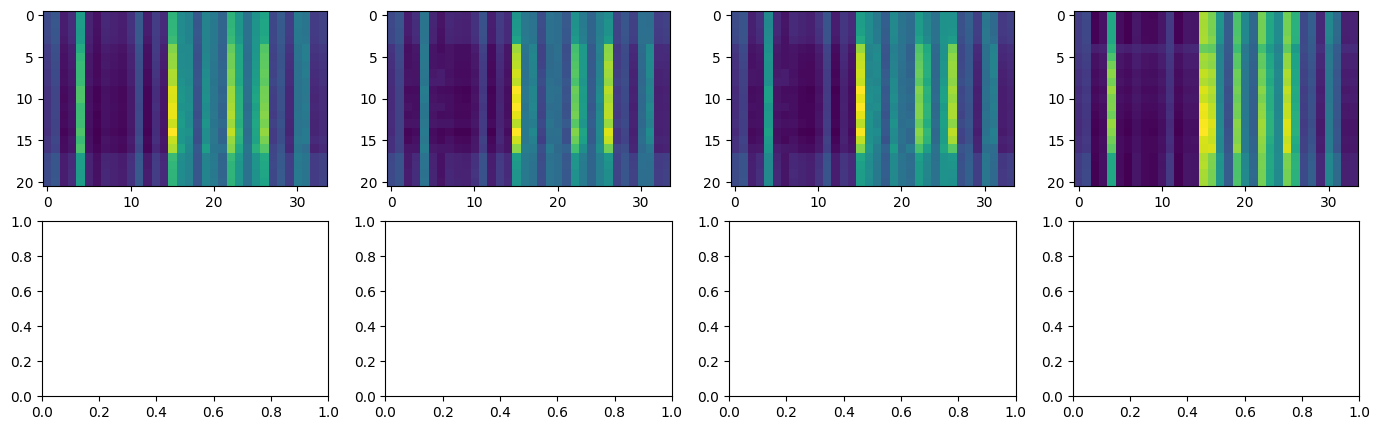

In [93]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(17, 5))

for i, w in enumerate(weight):
    ax = axs.ravel()[i]

    ax.imshow(w)

# ProteinPeptideInteractionModelWithSmartGateMask 16 heads

In [96]:
best_model_path = "/home/user11/results/models/ProteinPeptideInteractionModelWithSmartGateMask/version_1/checkpoints/best_model_epoch=epoch=51-auroc=validation_auroc=0.8253.ckpt"
obj_model = ProteinPeptideInteractionModelWithSmartGateMask(embedding_dim=1152, hidden_dim=512, num_heads=16, dropout=0.2)
model = LModelAMask.load_from_checkpoint(best_model_path, model=obj_model)

In [98]:
weight = 0
for protein, peptide_padded, mask, score, hla in tqdm(DataLoader(MHCSequenceDatasetMasked(val_data), batch_size=2058)):
    weight += model(protein.to(device), peptide_padded.to(device), mask.to(device))[3].detach().cpu().numpy().sum(axis=0)

100%|██████████| 13/13 [01:09<00:00,  5.36s/it]


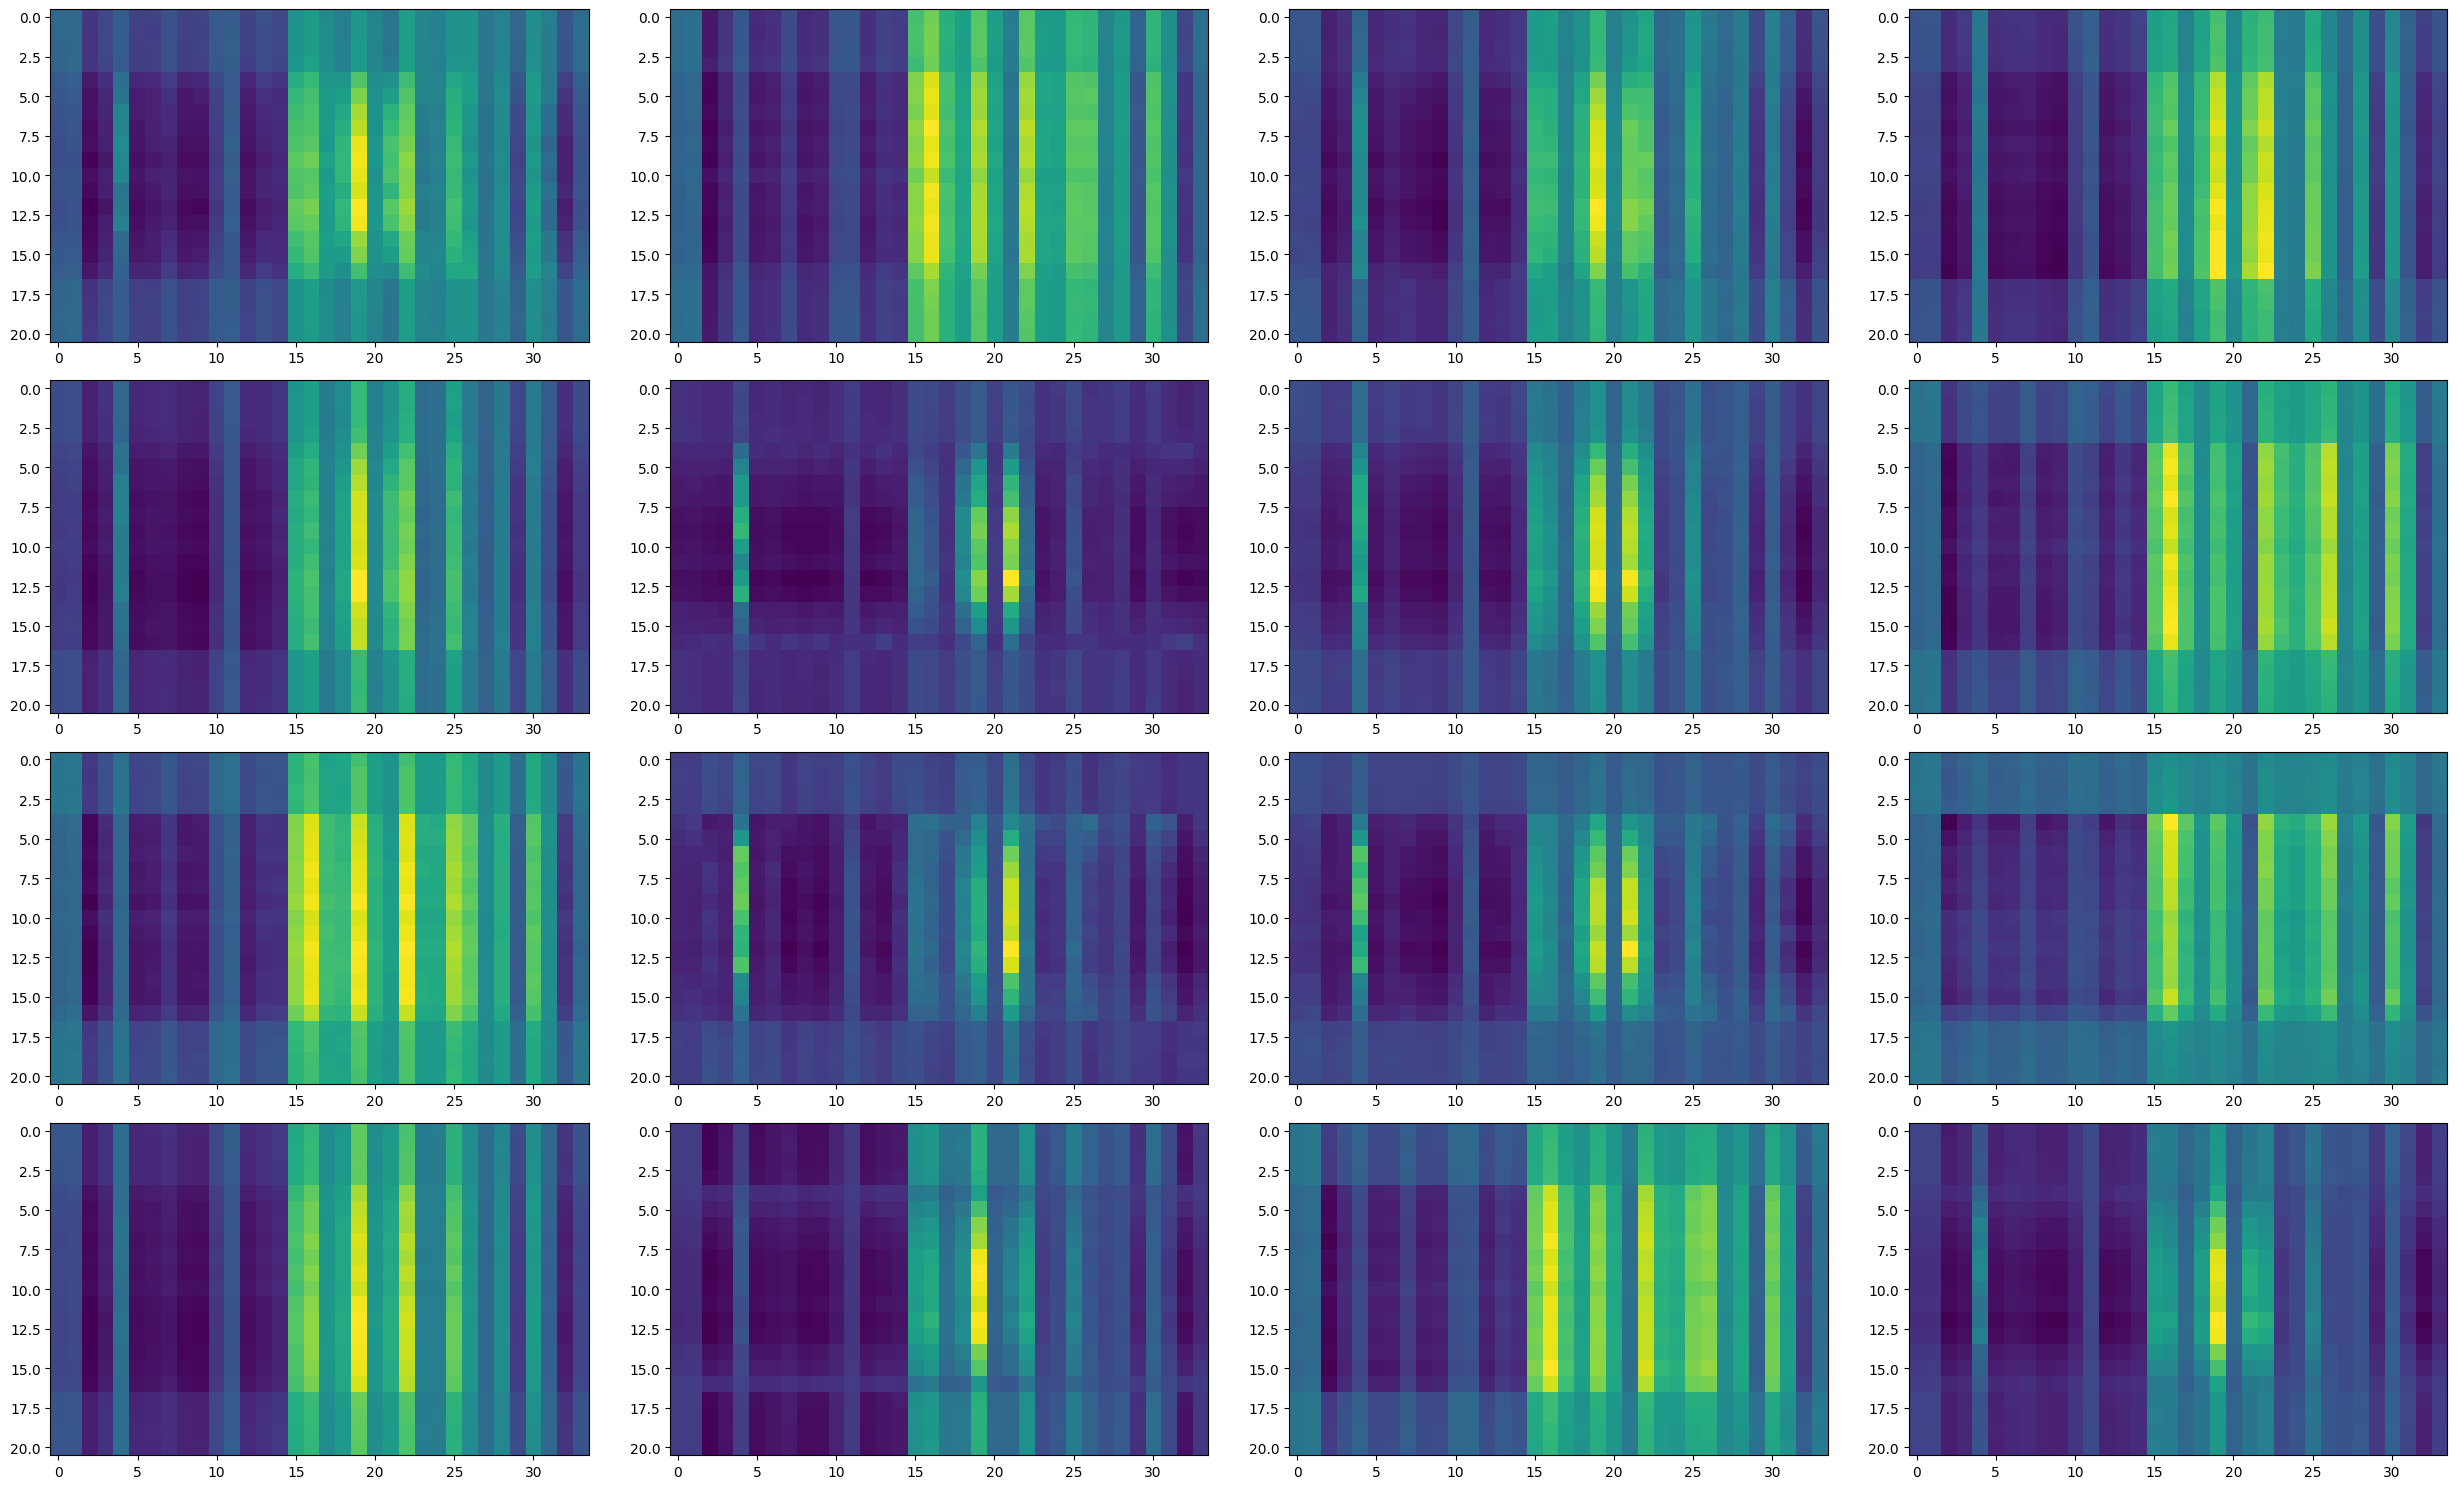

In [ ]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(25, 15))

for i, w in enumerate(weight):
    ax = axs.ravel()[i]
    ax.imshow(w)

plt.tight_layout()

# Saliency

In [ ]:
result_importance_protein  = 0
result_importance_peptide  = 0

for protein, peptide_padded, peptide_len, score, hla in tqdm(DataLoader(MHCSequenceDataset(val_data), batch_size=1)):
    protein_importance, peptide_importance = compute_saliency(model.to(device), protein.to(device), peptide_padded.to(device))
    result_importance_protein += protein_importance
    result_importance_peptide += peptide_importance

100%|██████████| 26343/26343 [04:53<00:00, 89.83it/s] 


In [50]:
result_importance_protein.detach().cpu().numpy()

array([[26258.852, 26718.908, 20566.76 , 22289.46 , 45190.32 , 21068.863,
        21563.889, 21490.459, 20002.197, 20150.512, 24286.613, 30907.896,
        21140.867, 21666.9  , 23869.998, 44529.066, 46382.727, 35903.99 ,
        46765.78 , 64307.42 , 38605.145, 58310.793, 47824.695, 31219.379,
        33452.793, 45201.6  , 35041.285, 31606.93 , 35966.918, 25373.846,
        35770.18 , 29419.045, 22169.443, 25944.041]], dtype=float32)

<BarContainer object of 34 artists>

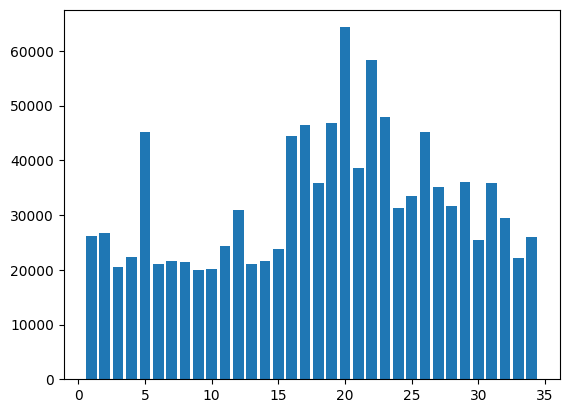

In [51]:
plt.bar(np.arange(1, 35), result_importance_protein.detach().cpu().numpy()[0])

<BarContainer object of 21 artists>

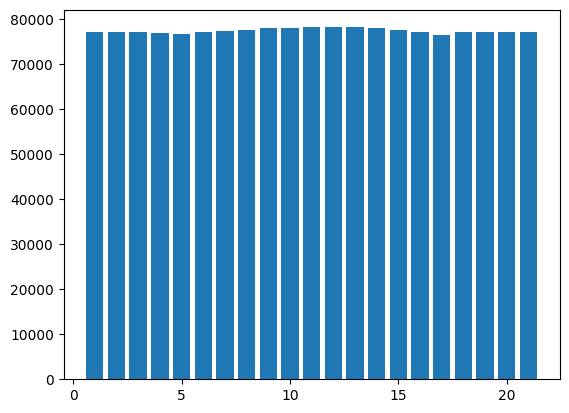

In [53]:
plt.bar(np.arange(1, 22), result_importance_peptide.detach().cpu().numpy()[0])


  0%|          | 2/26343 [00:00<24:19, 18.04it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


  0%|          | 5/26343 [00:00<29:11, 15.03it/s]


<class 'torch.Tensor'>
<class 'torch.Tensor'>


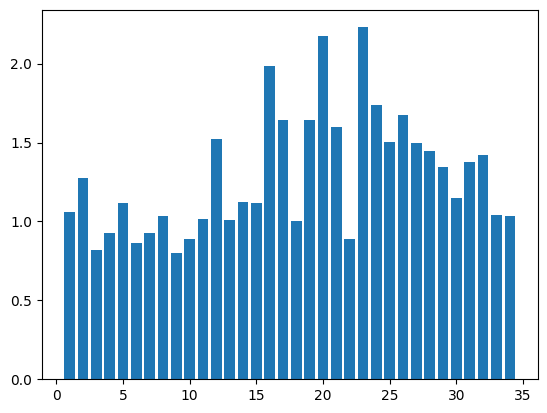

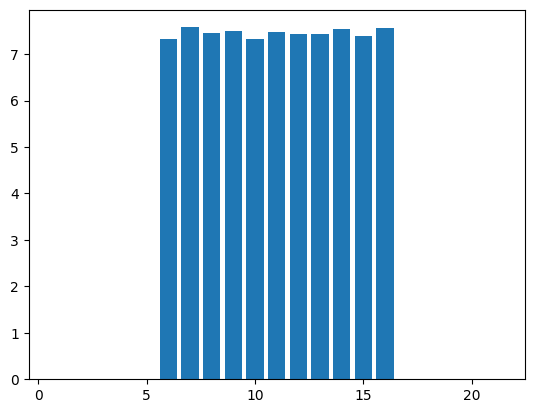

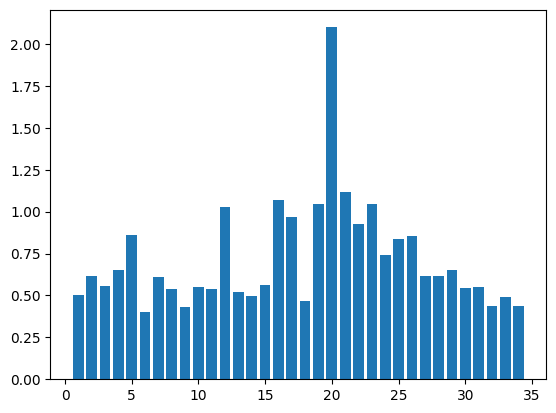

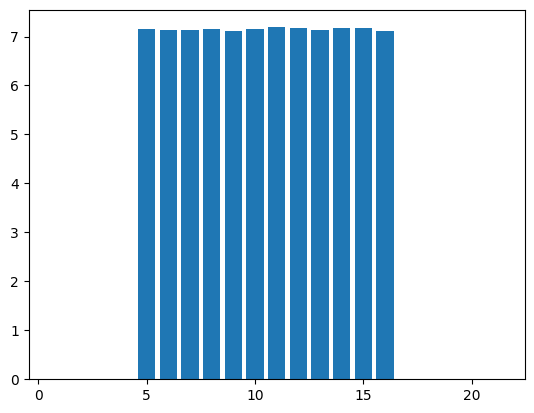

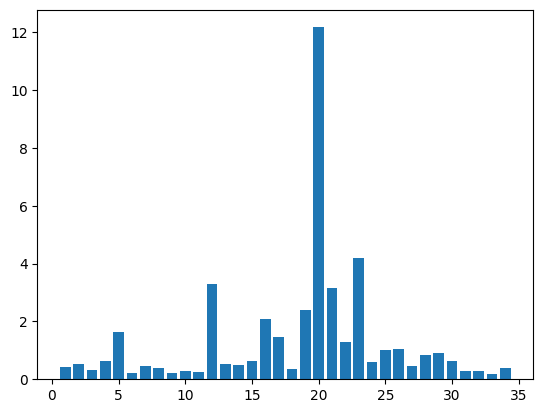

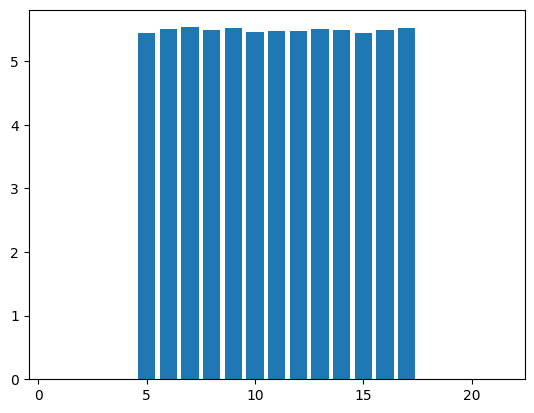

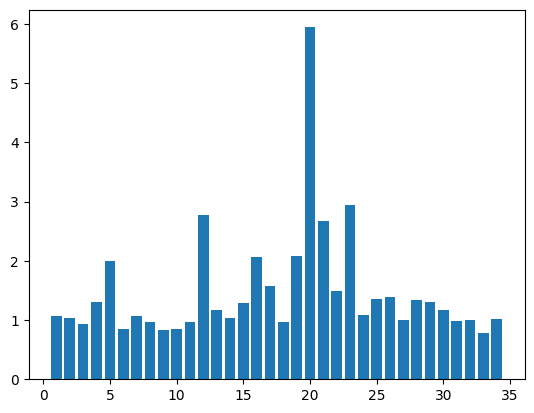

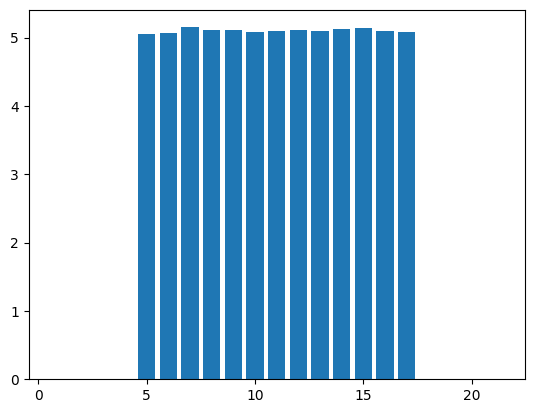

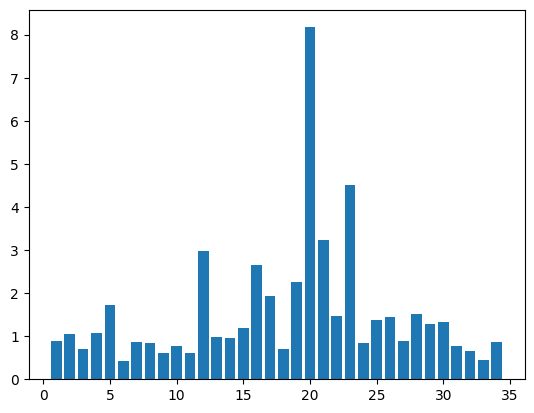

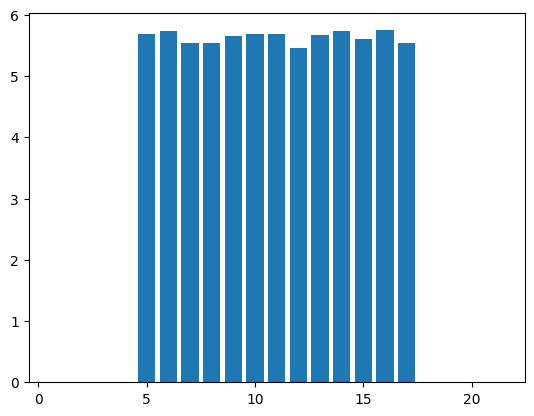

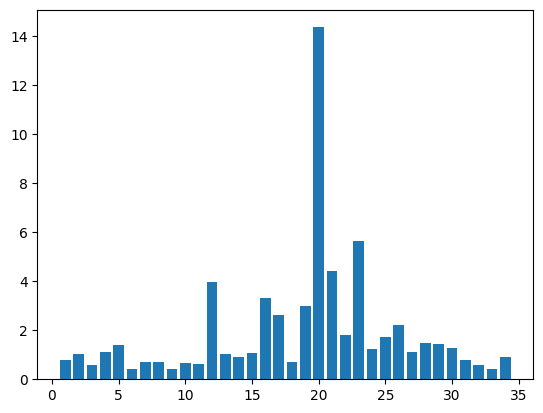

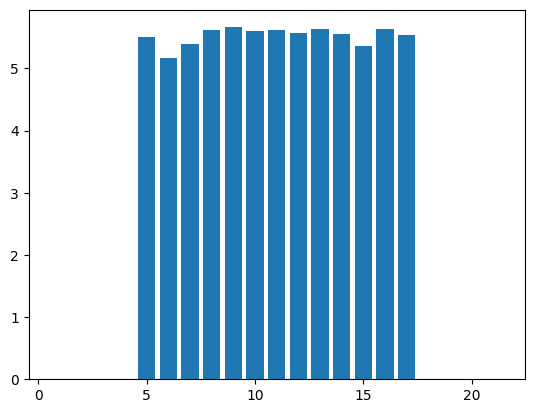

In [118]:
def compute_saliency_mask(model, protein, peptide, mask):
    protein.requires_grad_(True)
    peptide.requires_grad_(True)
    output = model(protein, peptide, mask)[0]
    output.backward()
    
    # Aggregate gradients
    protein_importance = protein.grad.norm(dim=-1)  # [B, 34]
    peptide_importance = peptide.grad.norm(dim=-1)   # [B, 21]
    return protein_importance, peptide_importance

i = 0
for protein, peptide_padded, mask, score, hla in tqdm(DataLoader(MHCSequenceDatasetMasked(val_data), batch_size=1)):
    print(type(mask))
    protein_importance, peptide_importance = compute_saliency_mask(model.to(device), protein.to(device), peptide_padded.to(device), mask.to(device))

    plt.figure()
    plt.bar(np.arange(1, 35), protein_importance.detach().cpu().numpy()[0])
    plt.figure()
    plt.bar(np.arange(1, 22), peptide_importance.detach().cpu().numpy()[0])


    if i == 5:
        break
    else:
        i += 1

# ProteinPeptideInteractionModelWithSmartGateAndWeighting

In [15]:
class ProteinPeptideInteractionModelWithSmartGateAndWeighting(nn.Module):
    def __init__(self, embedding_dim=1152, hidden_dim=512, num_heads=4, dropout=0.3):
        super(ProteinPeptideInteractionModelWithSmartGateAndWeighting, self).__init__()
        
        self.peptide_proj = nn.Linear(embedding_dim, hidden_dim)
        self.protein_proj = nn.Linear(embedding_dim, hidden_dim)
        
        self.cross_attn = nn.MultiheadAttention(embed_dim=hidden_dim, 
                                                num_heads=num_heads, 
                                                batch_first=True,
                                                dropout=dropout)
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1),
        )
        
        self.gate  = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 2)
        )

        self.peptide_importance = nn.Sequential(
            nn.Linear(hidden_dim, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1)
        )

    def forward(self, protein, peptide):
        # protein: [B, 34, 1152]
        # peptide: [B, 21, 1152]
        
        # Проецируем эмбеддинги
        protein_proj = self.protein_proj(protein)   # [B, 34, hidden]
        peptide_proj = self.peptide_proj(peptide)   # [B, 21, hidden]
        
        # Кросс-аттеншн: пептид (query) взаимодействует с белком (key, value)
        attn_output, attn_weights = self.cross_attn(query=peptide_proj,
                                         key=protein_proj,
                                         value=protein_proj,
                                        average_attn_weights=False)
        # Агрегируем: берем среднее по всем позициям пептида
        attn_repr = attn_output.mean(dim=1)        # [B, hidden]

        pep_weights = self.peptide_importance(peptide_proj)
        pep_repr = (peptide_proj * pep_weights.softmax(dim=1)).sum(dim=1) # [B, hidden]
        
        combined_1 = torch.cat([attn_repr, pep_repr], dim=1)  # [B, hidden*2]
        alpha, beta = self.gate(combined_1).chunk(chunks=2, dim=-1)

        combined_2 = torch.cat([attn_repr * alpha, pep_repr * beta], dim=1)
        output = self.fc(combined_2)

        return output, combined_1, combined_2, attn_weights

In [16]:
best_model_path = "/home/user11/results/models/ProteinPeptideInteractionModelWithSmartGateAndWeighting/version_0/checkpoints/best_model_epoch=epoch=52-auroc=validation_auroc=0.8300.ckpt"
obj_model = ProteinPeptideInteractionModelWithSmartGateAndWeighting(embedding_dim=1152, hidden_dim=512, num_heads=8, dropout=0.2)
model = LModelA.load_from_checkpoint(best_model_path, model=obj_model)

In [225]:
for protein, peptide_padded, _, score, hla in tqdm(DataLoader(MHCSequenceDataset(val_data), batch_size=3000)):
    output, combined_1, combined_2, attn_weights = model(protein.to(device), peptide_padded.to(device))

    break

  0%|          | 0/9 [00:15<?, ?it/s]


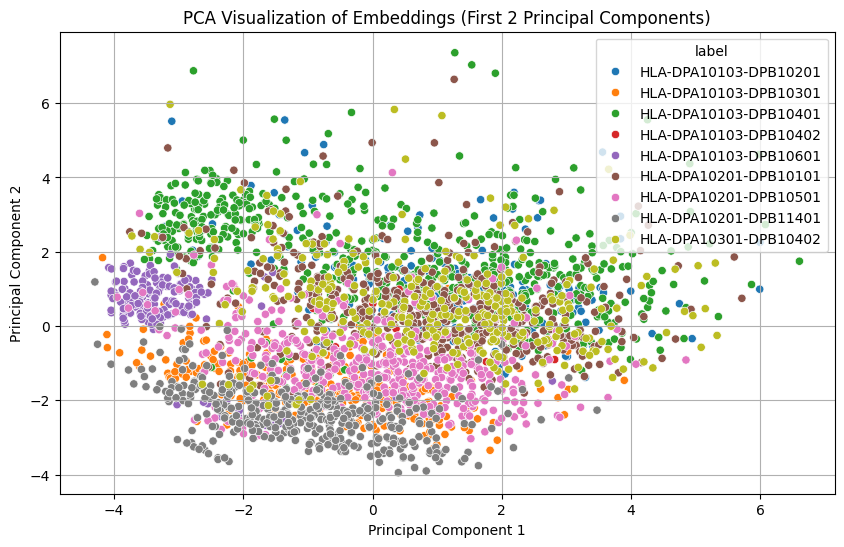

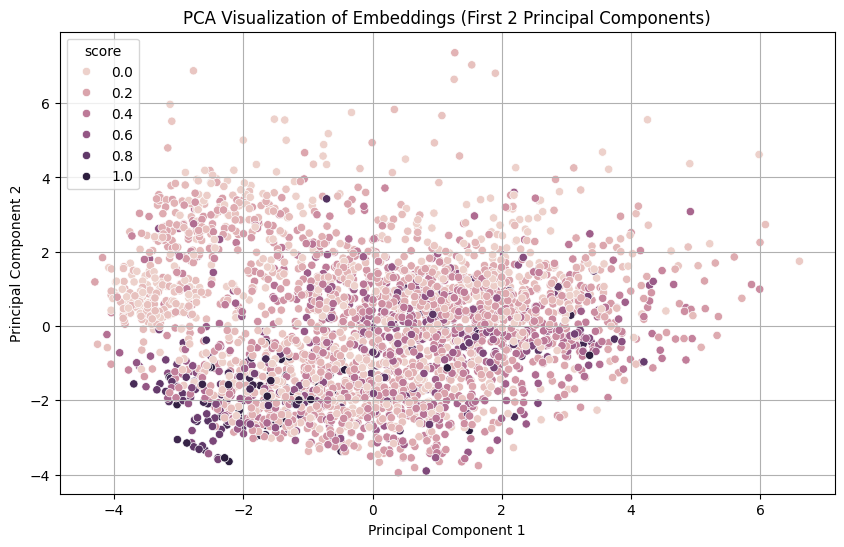

In [226]:
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(combined_2.detach().cpu().numpy())

viz_df = pd.DataFrame(reduced_embeddings, columns=['PC1', 'PC2'])
viz_df["label"] = hla
viz_df["score"] = score

plt.figure(figsize=(10, 6))
# plt.scatter(viz_df['PC1'], viz_df['PC2'], alpha=0.7, edgecolor='k', c=y_int)
sns.scatterplot(data=viz_df, x="PC1", y="PC2", hue="label")
plt.title('PCA Visualization of Embeddings (First 2 Principal Components)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
# plt.scatter(viz_df['PC1'], viz_df['PC2'], alpha=0.7, edgecolor='k', c=y_int)
sns.scatterplot(data=viz_df, x="PC1", y="PC2", hue="score")
plt.title('PCA Visualization of Embeddings (First 2 Principal Components)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

In [228]:
weight = 0
for protein, peptide_padded, _, score, hla in tqdm(DataLoader(MHCSequenceDataset(val_data), batch_size=2058)):
    weight += model(protein.to(device), peptide_padded.to(device))[3].detach().cpu().numpy().sum(axis=0)

100%|██████████| 13/13 [02:21<00:00, 10.90s/it]


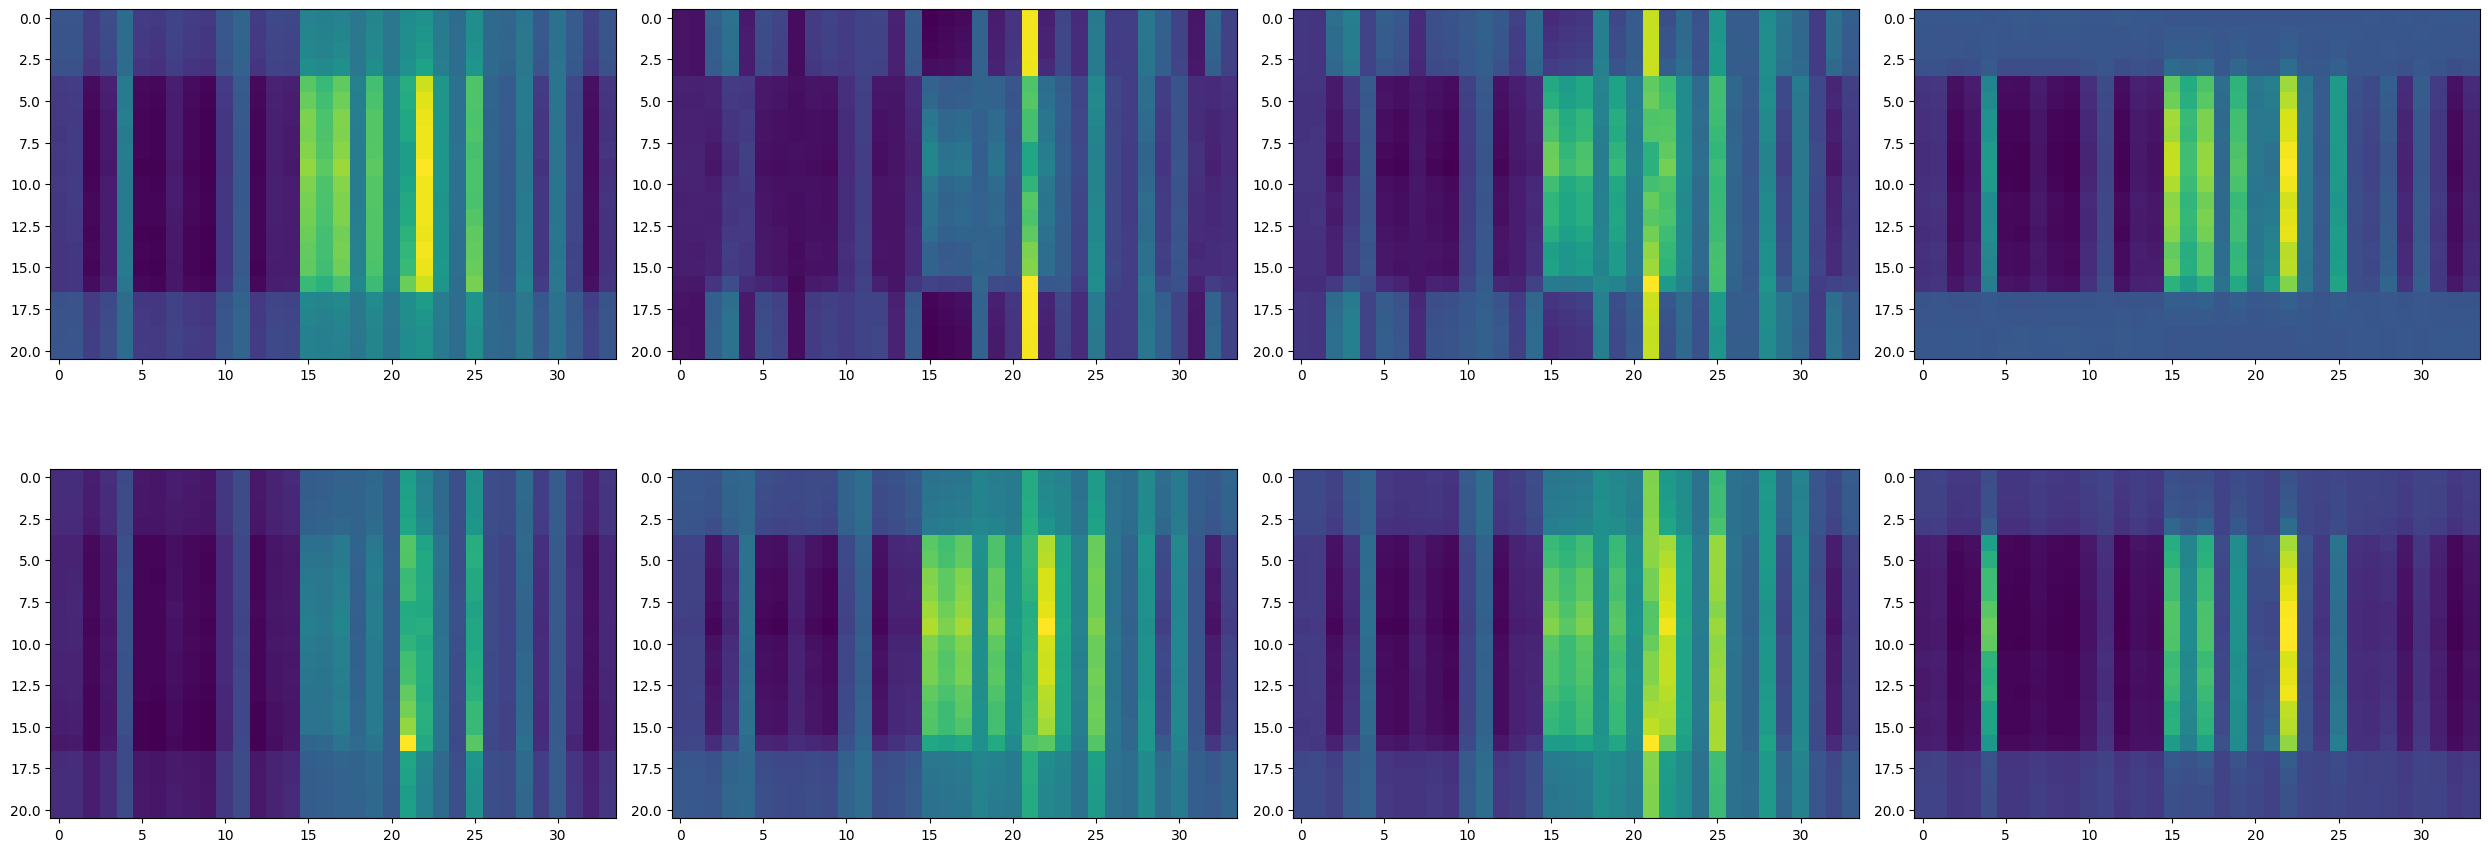

In [230]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(25, 10))

for i, w in enumerate(weight):
    ax = axs.ravel()[i]
    ax.imshow(w)

plt.tight_layout()

In [17]:
result_importance_protein  = 0
result_importance_peptide  = 0

for protein, peptide_padded, peptide_len, score, hla in tqdm(DataLoader(MHCSequenceDataset(val_data), batch_size=1)):
    protein_importance, peptide_importance = compute_saliency(model.to(device), protein.to(device), peptide_padded.to(device))
    result_importance_protein += protein_importance
    result_importance_peptide += peptide_importance

  0%|          | 0/26343 [00:00<?, ?it/s]/home/user11/.conda/envs/esm/lib/python3.11/site-packages/torch/autograd/graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 26343/26343 [05:03<00:00, 86.88it/s] 


<BarContainer object of 34 artists>

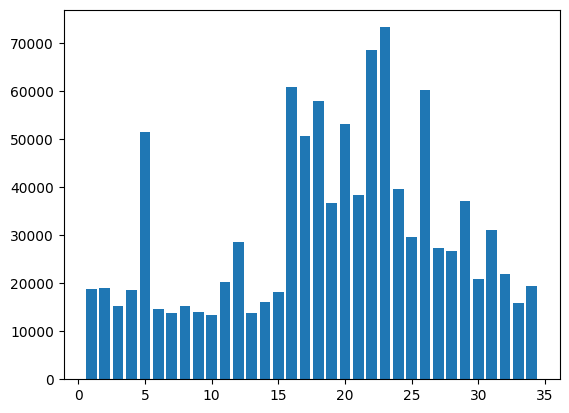

In [18]:
plt.bar(np.arange(1, 35), result_importance_protein.detach().cpu().numpy()[0])

<BarContainer object of 21 artists>

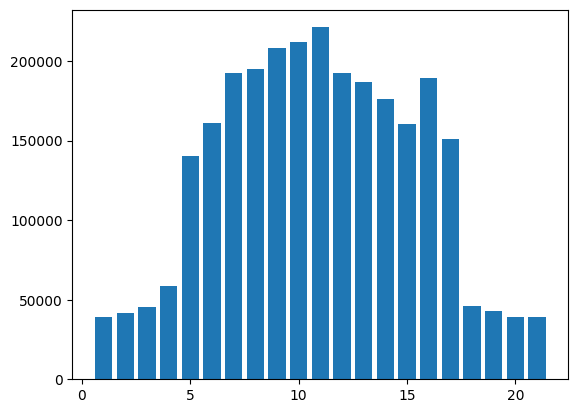

In [21]:
plt.bar(np.arange(1, 22), result_importance_peptide.detach().cpu().numpy()[0])


  0%|          | 2/26343 [00:00<28:24, 15.46it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


  0%|          | 5/26343 [00:00<31:41, 13.85it/s]


<class 'torch.Tensor'>
<class 'torch.Tensor'>


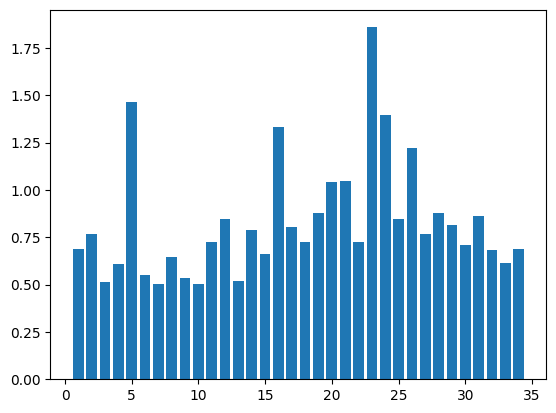

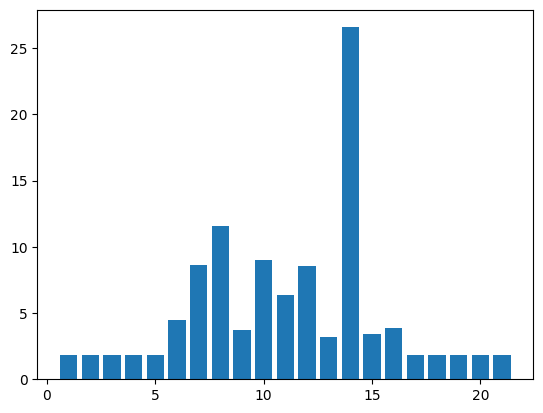

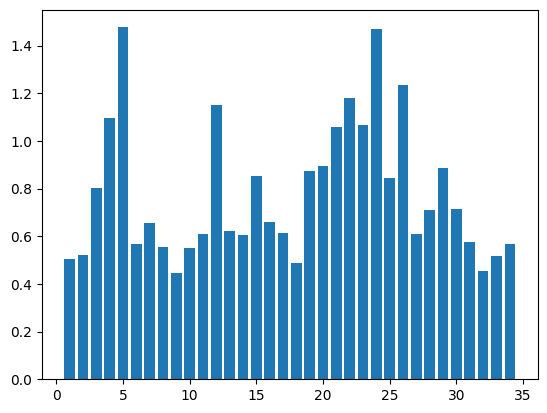

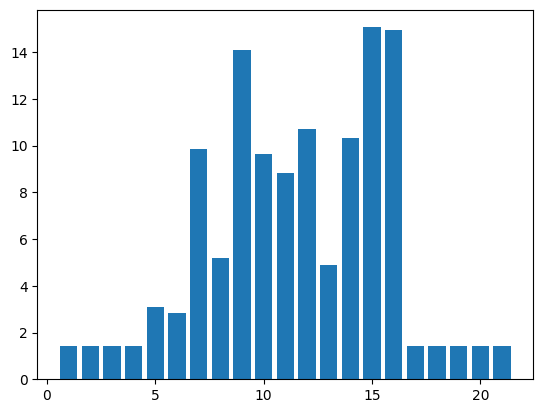

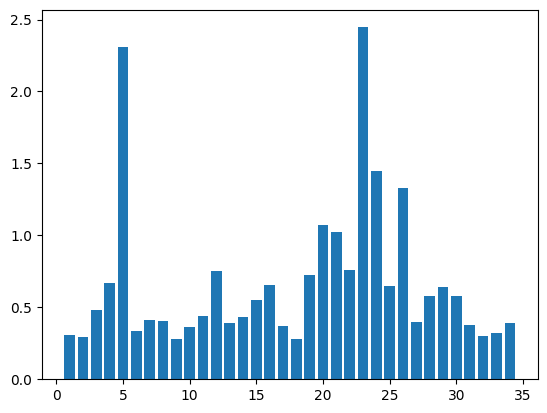

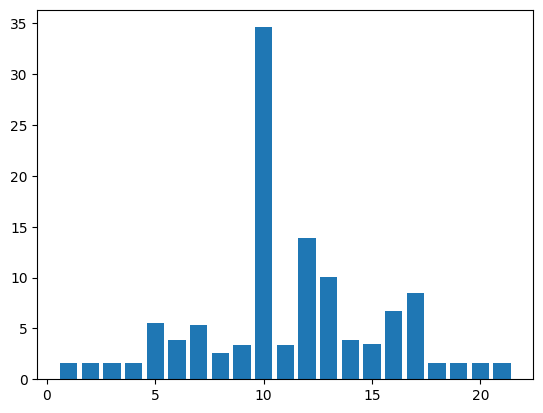

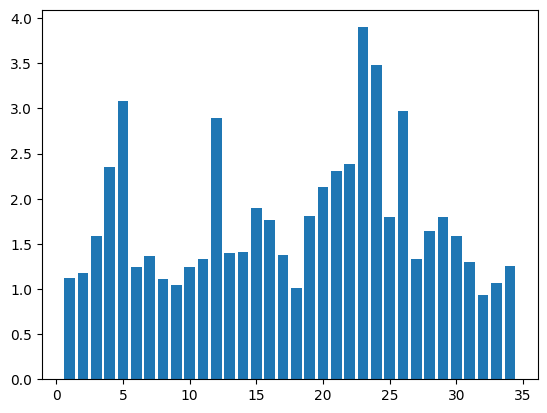

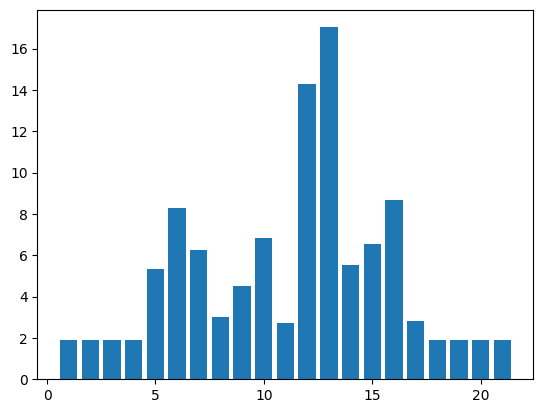

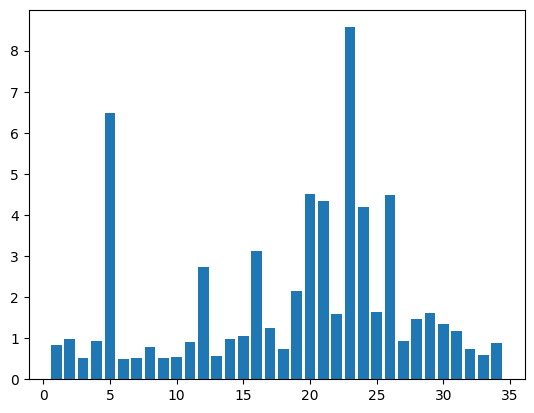

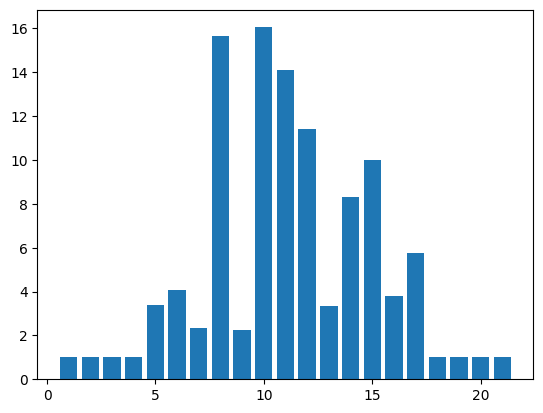

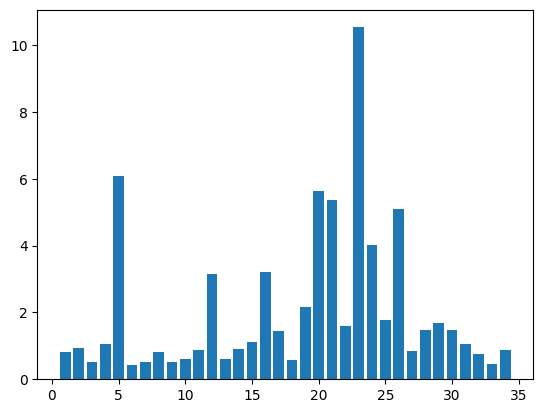

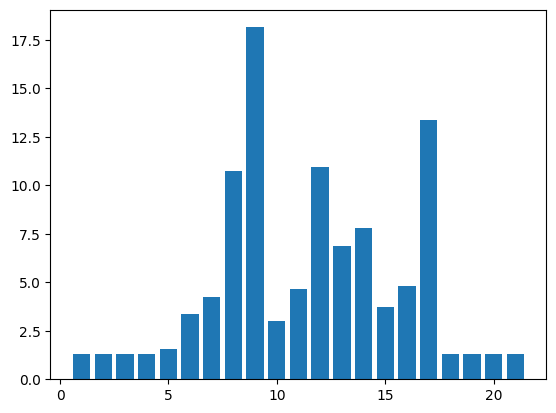

In [234]:
i = 0
for protein, peptide_padded, mask, score, hla in tqdm(DataLoader(MHCSequenceDatasetMasked(val_data), batch_size=1)):
    print(type(mask))
    protein_importance, peptide_importance = compute_saliency(model.to(device), protein.to(device), peptide_padded.to(device))

    plt.figure()
    plt.bar(np.arange(1, 35), protein_importance.detach().cpu().numpy()[0])
    plt.figure()
    plt.bar(np.arange(1, 22), peptide_importance.detach().cpu().numpy()[0])


    if i == 5:
        break
    else:
        i += 1

# Occlusion

In [231]:
def occlusion_analysis(model, protein, peptide, window_size=1, stride=1):
    """
    Perform occlusion study on protein-peptide complexes
    
    Args:
        model: Trained ProteinPeptideInteractionModel
        protein: Input protein tensor [B, L_protein, D]
        peptide: Input peptide tensor [B, L_peptide, D]
        window_size: Number of adjacent residues to occlude (1 for single residue)
        stride: Step size for occlusion window
        
    Returns:
        protein_importance: [B, L_protein] occlusion scores
        peptide_importance: [B, L_peptide] occlusion scores
    """
    model.eval()
    device = next(model.parameters()).device
    
    batch_size, L_protein, _ = protein.shape
    _, L_peptide, _ = peptide.shape
    
    # Get baseline prediction
    with torch.no_grad():
        baseline = model(protein.to(device), peptide.to(device))[0]  # [B, 1]
    
    # Initialize importance matrices
    protein_importance = torch.zeros(batch_size, L_protein)
    peptide_importance = torch.zeros(batch_size, L_peptide)
    
    # Protein occlusion
    for i in tqdm(range(0, L_protein - window_size + 1, stride), desc="Occluding protein"):
        protein_occluded = protein.clone()
        protein_occluded[:, i:i+window_size] = 0  # Zero out window
        
        with torch.no_grad():
            occluded_out = model(protein_occluded.to(device), peptide.to(device))[0]
        
        delta = (baseline - occluded_out).abs()  # [B, 1]
        protein_importance[:, i:i+window_size] += delta.view(-1, 1)
    
    # Peptide occlusion
    for j in tqdm(range(0, L_peptide - window_size + 1, stride), desc="Occluding peptide"):
        peptide_occluded = peptide.clone()
        peptide_occluded[:, j:j+window_size] = 0
        
        with torch.no_grad():
            occluded_out = model(protein.to(device), peptide_occluded.to(device))[0]
        
        delta = (baseline - occluded_out).abs()
        peptide_importance[:, j:j+window_size] += delta.view(-1, 1)
    
    # Normalize by number of overlapping windows
    protein_importance /= window_size
    peptide_importance /= window_size
    
    return protein_importance.cpu(), peptide_importance.cpu()

def visualize_occlusion(protein_imp, peptide_imp, protein_seq=None, peptide_seq=None, sample_idx=0):
    """Visualize occlusion results for one sample"""
    plt.figure(figsize=(15, 5))
    
    # Protein importance
    plt.subplot(2, 1, 1)
    xs = np.arange(len(protein_imp[sample_idx]))
    plt.bar(xs, protein_imp[sample_idx])
    if protein_seq:
        plt.xticks(xs, list(protein_seq), rotation=90)
    plt.title("Protein Residue Importance (Occlusion)")
    plt.xlabel("Residue Position")
    plt.ylabel("Δ Prediction Score")
    
    # Peptide importance
    plt.subplot(2, 1, 2)
    xs = np.arange(len(peptide_imp[sample_idx]))
    plt.bar(xs, peptide_imp[sample_idx])
    if peptide_seq:
        plt.xticks(xs, list(peptide_seq), rotation=90)
    plt.title("Peptide Residue Importance (Occlusion)")
    plt.xlabel("Peptide Position")
    plt.ylabel("Δ Prediction Score")
    
    plt.tight_layout()
    plt.show()


In [162]:
# Get sample batch
val_dataset = MHCSequenceDataset(val_data)
dataloader = DataLoader(val_dataset, batch_size=4096)
protein, peptide, _, _, _ = next(iter(dataloader))

# Run occlusion analysis
protein_imp, peptide_imp = occlusion_analysis(
    model.cpu(), 
    protein, 
    peptide,
    window_size=1,  # Occlude single residues
    stride=1
)

# # Visualize first sample
# visualize_occlusion(
#     protein_imp, 
#     peptide_imp,
#     sample_idx=0
# )

Occluding peptide: 100%|██████████| 21/21 [00:33<00:00,  1.58s/it]


<BarContainer object of 34 artists>

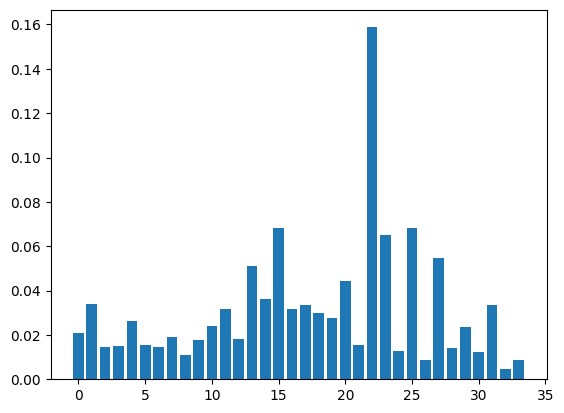

In [163]:
plt.bar(np.arange(protein_imp.shape[1]), torch.mean(protein_imp, axis=0))

<BarContainer object of 21 artists>

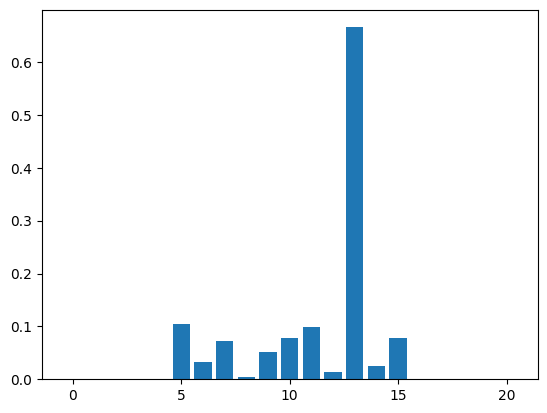

In [164]:
plt.bar(np.arange(peptide_imp.shape[1]), torch.mean(peptide_imp, axis=0))